In [3]:
import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage

In [4]:
import os
import glob
import rasterio
import numpy as np
import pandas as pd
import scipy.ndimage
from rasterio.warp import calculate_default_transform, reproject, Resampling

def process_tiff(file_path, output_folder, bird_name, week_num):
    # Open the raster file
    with rasterio.open(file_path) as src:
        # Reproject to WGS84
        dst_crs = 'EPSG:4326'  # WGS84
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        reprojected_file = 'eBirdData/reprojected.tif'
        with rasterio.open(reprojected_file, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

        # Process the reprojected data
        with rasterio.open(reprojected_file) as dataset:
            data = dataset.read(1) 
            transform_affine = dataset.transform 

            # Get the coordinates of each pixel
            rows, cols = np.indices(data.shape)
            xs = transform_affine[2] + cols * transform_affine[0] + rows * transform_affine[1]
            ys = transform_affine[5] + cols * transform_affine[3] + rows * transform_affine[4]

            # Flatten the arrays
            xs = xs.flatten()
            ys = ys.flatten()
            values = data.flatten()

            # Create a DataFrame
            df = pd.DataFrame({
                'longitude': xs,
                'latitude': ys,
                'value': values
            })

        # Filter the DataFrame
        filtered_df = df[
            (df['latitude'] >= 24.75) & (df['latitude'] <= 49.25) &
            (df['longitude'] >= -124.75) & (df['longitude'] <= -67.25)
        ]
        amerob = filtered_df.fillna(0).pivot_table(index='latitude', columns='longitude', values='value', aggfunc='mean')
        amerob = np.floor(amerob).astype(int)
        amerob = amerob.clip(upper=7)

        # Resetting the index to replace lat/lon with normal integer index
        amerob = amerob.reset_index(drop=True)
        amerob.columns = range(amerob.shape[1])

        # Scale dimensions
        data = amerob.to_numpy()
        rescaled_data = scipy.ndimage.zoom(data, (98 / data.shape[0], 230 / data.shape[1]), order=1)
        amerob_rescaled = pd.DataFrame(rescaled_data)

        # Expand array (this part was missing usage before)
        scale_factor = 4
        data = amerob_rescaled.values
        expanded_array = np.zeros((data.shape[0] * scale_factor, data.shape[1] * scale_factor))
        expanded_array[::scale_factor, ::scale_factor] = data

        # Use expanded_array in rescaling
        new_index = np.linspace(amerob_rescaled.index.min(), amerob_rescaled.index.max(), expanded_array.shape[0])
        new_columns = np.linspace(amerob_rescaled.columns.min(), amerob_rescaled.columns.max(), expanded_array.shape[1])
        amerob_rescaled = pd.DataFrame(expanded_array)

        original_sum = amerob.sum().sum()
        rescaled_sum = amerob_rescaled.sum().sum()
        adjustment_factor = original_sum / rescaled_sum
        amerob_rescaled = amerob_rescaled * adjustment_factor

        # Rescale based on sum
        # desired_sum = 20000
        # scaling_factor = desired_sum / amerob_rescaled.sum().sum()
        # amerob_rescaled = amerob_rescaled * scaling_factor
        amerob_rescaled = amerob_rescaled.round().astype(int)

        # Save to parquet
        output_file = f'{output_folder}/{week_num}_{bird_name}_2022.parquet'
        amerob_rescaled.to_parquet(output_file)

# Process all .tif files in a given folder
def process_folder(input_folder, output_folder, bird_name):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    tiff_files = glob.glob(f'{input_folder}/*.tif')
    for i, tiff_file in enumerate(tiff_files):
        process_tiff(tiff_file, output_folder, bird_name, i + 1)
        print(f'Processed {tiff_file}')

# Paths for the two bird species
amerob_input_folder = "eBirdData/amerob"
amecro_input_folder = "eBirdData/amecro"

amerob_output_folder = "eBirdData/processed_amerob"
amecro_output_folder = "eBirdData/processed_amecro"

# Process the folders
process_folder(amerob_input_folder, amerob_output_folder, 'amerob')
process_folder(amecro_input_folder, amecro_output_folder, 'amecro')

Processed eBirdData/amerob\amerob_abundance_median_2022-01-04.tif
Processed eBirdData/amerob\amerob_abundance_median_2022-01-11.tif
Processed eBirdData/amerob\amerob_abundance_median_2022-01-18.tif
Processed eBirdData/amerob\amerob_abundance_median_2022-01-25.tif
Processed eBirdData/amerob\amerob_abundance_median_2022-02-01.tif
Processed eBirdData/amerob\amerob_abundance_median_2022-02-08.tif
Processed eBirdData/amerob\amerob_abundance_median_2022-02-15.tif
Processed eBirdData/amerob\amerob_abundance_median_2022-02-22.tif
Processed eBirdData/amerob\amerob_abundance_median_2022-03-01.tif
Processed eBirdData/amerob\amerob_abundance_median_2022-03-08.tif
Processed eBirdData/amerob\amerob_abundance_median_2022-03-15.tif
Processed eBirdData/amerob\amerob_abundance_median_2022-03-22.tif
Processed eBirdData/amerob\amerob_abundance_median_2022-03-29.tif
Processed eBirdData/amerob\amerob_abundance_median_2022-04-05.tif
Processed eBirdData/amerob\amerob_abundance_median_2022-04-12.tif
Processed 

width of 13,314 pixels and a height of 6,081 pixels.

In [13]:
# Open the raster file
file_path = "eBirdData/amerob/amerob_abundance_median_2022-01-04.tif"
with rasterio.open(file_path) as src:
    # Reproject to WGS84
    dst_crs = 'EPSG:4326'  # WGS84
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('eBirdData/reprojected.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)


with rasterio.open('eBirdData/reprojected.tif') as dataset:
    data = dataset.read(1) 
    transform_affine = dataset.transform 

    # Get the coordinates of each pixel
    rows, cols = np.indices(data.shape)
    xs = transform_affine[2] + cols * transform_affine[0] + rows * transform_affine[1]
    ys = transform_affine[5] + cols * transform_affine[3] + rows * transform_affine[4]
    
    # Flatten the arrays
    xs = xs.flatten()
    ys = ys.flatten()
    values = data.flatten()

    # Create a DataFrame
    df = pd.DataFrame({
        'longitude': xs,
        'latitude': ys,
        'value': values
    })
df

,longitude,latitude,value
0,-180.000000,90.000000,NaN
1,-179.973355,90.000000,NaN
2,-179.946710,90.000000,NaN
3,-179.920065,90.000000,NaN
4,-179.893420,90.000000,NaN
...,...,...,...
76066925,179.866775,-59.984462,NaN
76066926,179.893420,-59.984462,NaN
76066927,179.920065,-59.984462,NaN
76066928,179.946710,-59.984462,NaN


Filter the DataFrame based on the specified latitude and longitude range <br>
Replace NaN values with 0. <br>
Convert to Integer <br>
Clip values above 7

In [14]:
filtered_df = df[
    (df['latitude'] >= 24.75) & (df['latitude'] <= 49.25) &
    (df['longitude'] >= -124.75) & (df['longitude'] <= -67.25)
]
amerob = filtered_df.fillna(0).pivot_table(index='latitude', columns='longitude', values='value', aggfunc='mean')
amerob = np.floor(amerob).astype(int)
amerob = amerob.clip(upper=7)
amerob

longitude,-124.738361,-124.711716,-124.685071,-124.658426,-124.631782,-124.605137,-124.578492,-124.551847,-124.525202,-124.498557,...,-67.504996,-67.478351,-67.451706,-67.425061,-67.398416,-67.371771,-67.345126,-67.318481,-67.291836,-67.265191
latitude,,,,,,,,,,,,,,,,,,,,,
24.773146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24.799790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24.826435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24.853080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24.879725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49.126636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49.153281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49.179926,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Convert coordinate indices to normal integer indeces for use in gird indexing

In [29]:
# Resetting the index to replace lat/lon with normal integer index
amerob = amerob.reset_index(drop=True)

# Rename columns to integer indices
amerob.columns = range(amerob.shape[1])
original_sum = amerob.sum().sum()
print(original_sum)
amerob

3047180


,0,1,2,3,4,5,6,7,8,9,...,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Scale up dimensions by: From '919 rows × 2158 columns' To '392 rows × 920 columns' <br>
Scale population by scale_populataion = NaN

In [34]:
data = amerob.to_numpy()
rescaled_data = scipy.ndimage.zoom(data, (98 / data.shape[0], 230 / data.shape[1]), order=1)
amerob_rescaled = pd.DataFrame(rescaled_data)

scale_factor = 4
data = amerob_rescaled.values
expanded_array = np.zeros((data.shape[0] * scale_factor, data.shape[1] * scale_factor))
expanded_array[::scale_factor, ::scale_factor] = data

rescaled_sum = amerob_rescaled.sum().sum()

new_index = np.linspace(amerob_rescaled.index.min(), amerob_rescaled.index.max(), expanded_array.shape[0])
new_columns = np.linspace(amerob_rescaled.columns.min(), amerob_rescaled.columns.max(), expanded_array.shape[1])
amerob_rescaled = pd.DataFrame(expanded_array)

adjustment_factor = original_sum / rescaled_sum
amerob_rescaled = amerob_rescaled * adjustment_factor

rescaled_sum_adjusted = amerob_rescaled.sum().sum()

# desired_sum = 20000
# scaling_factor = desired_sum / amerob_rescaled.sum().sum()
# amerob_rescaled = amerob_rescaled * scaling_factor

# Convert to integers
amerob_rescaled = amerob_rescaled.round().astype(int)


amerob_rescaled.to_parquet('amerob_2022-09-06.parquet')
print(rescaled_sum)
print(rescaled_sum_adjusted)
amerob_rescaled


34162
3047180.0


,0,1,2,3,4,5,6,7,8,9,...,910,911,912,913,914,915,916,917,918,919
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
388,0,0,0,0,178,0,0,0,178,0,...,0,0,0,0,0,0,0,0,0,0
389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Grid Distribution

In [35]:
value_counts = amerob_rescaled.apply(pd.Series.value_counts).sum(axis=1).fillna(0).astype(int)
distribution_df = pd.DataFrame({'Value': value_counts.index, 'Count': value_counts.values})
distribution_df


,Value,Count
0,0,351843
1,89,1704
2,178,1439
3,268,1231
4,357,940
5,446,782
6,535,690
7,624,2011


The largest number in the data is: 7


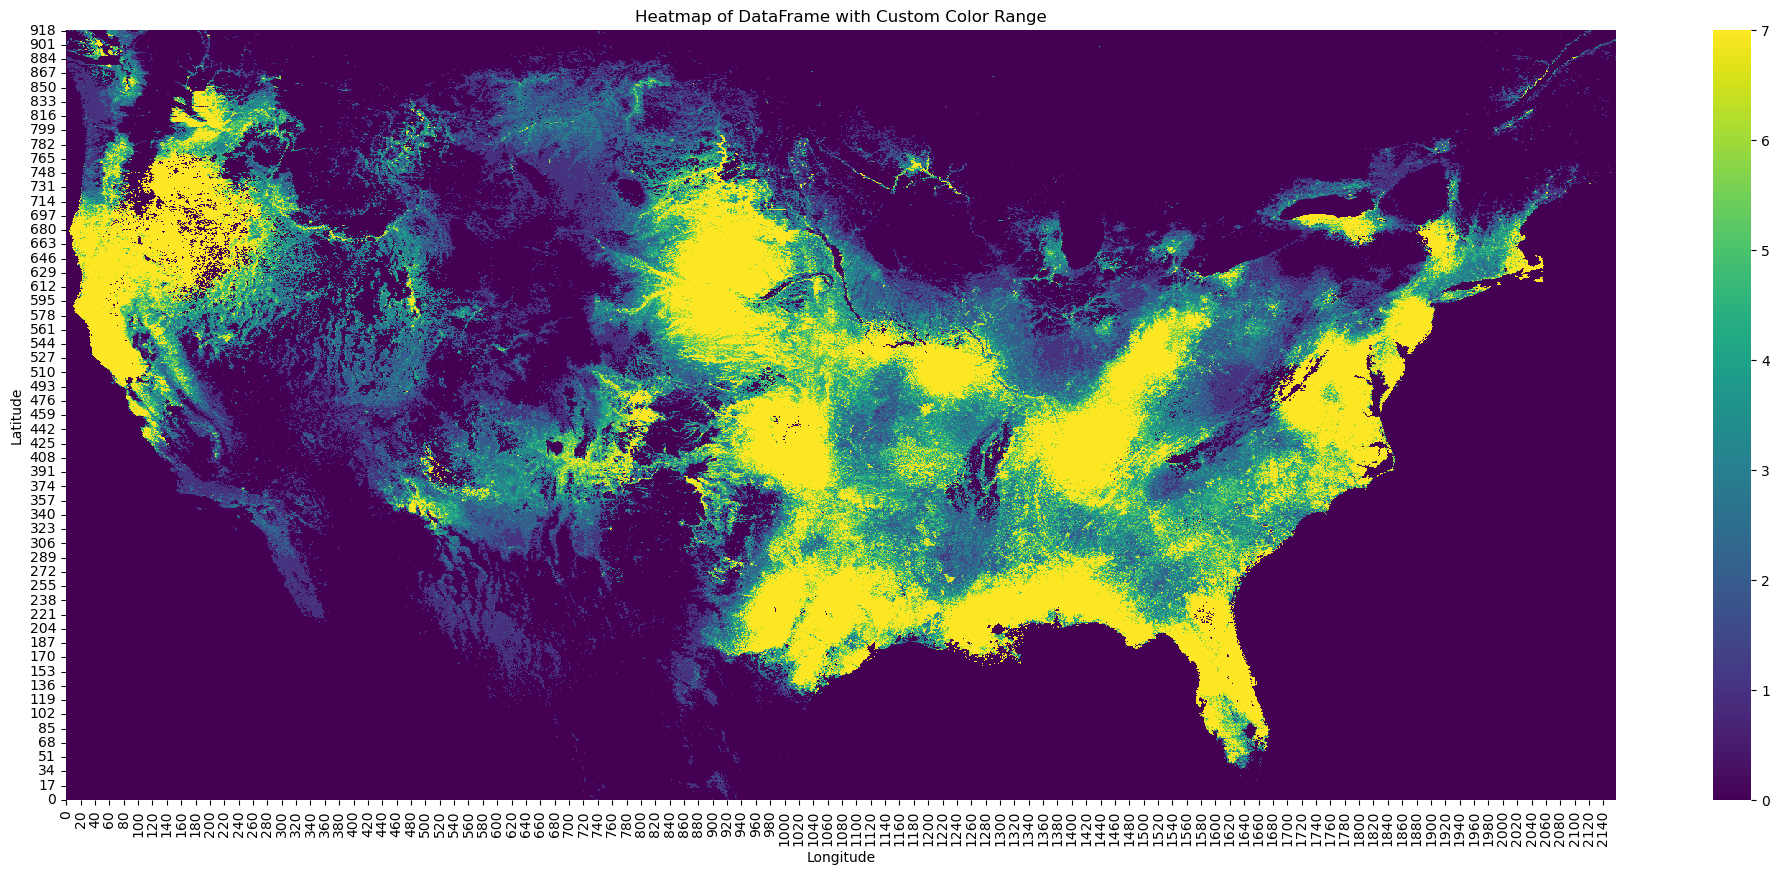

In [36]:
print(f"The largest number in the data is: {max_value}")

# Reverse the order of the latitude index
data_reversed = amerob.iloc[::-1]

# Set the color range with the maximum value
plt.figure(figsize=(25, 10))
sns.heatmap(data_reversed, cmap="viridis", cbar=True, vmin=0, vmax=max_value)

plt.title("Heatmap of DataFrame with Custom Color Range")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

The largest number in the data is: 7


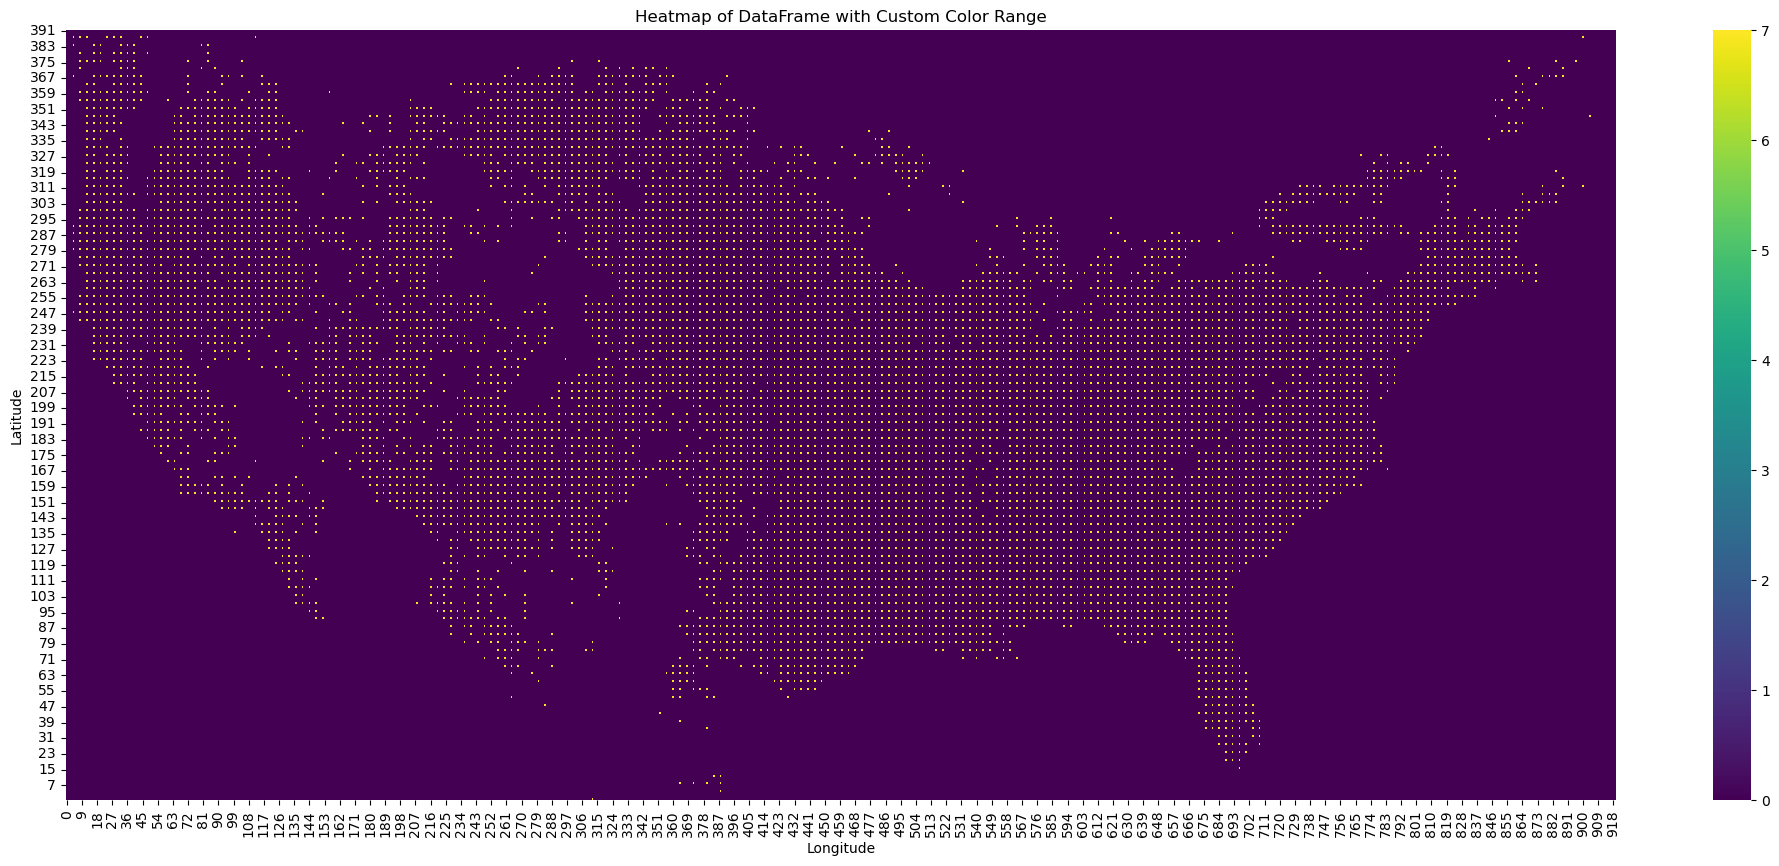

In [37]:
max_value = data.max().max()
print(f"The largest number in the data is: {max_value}")

# Reverse the order of the latitude index
data_reversed = amerob_rescaled.iloc[::-1]

# Set the color range with the maximum value
plt.figure(figsize=(25, 10))
sns.heatmap(data_reversed, cmap="viridis", cbar=True, vmin=0, vmax=max_value)

plt.title("Heatmap of DataFrame with Custom Color Range")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

The largest number in the data is: 7


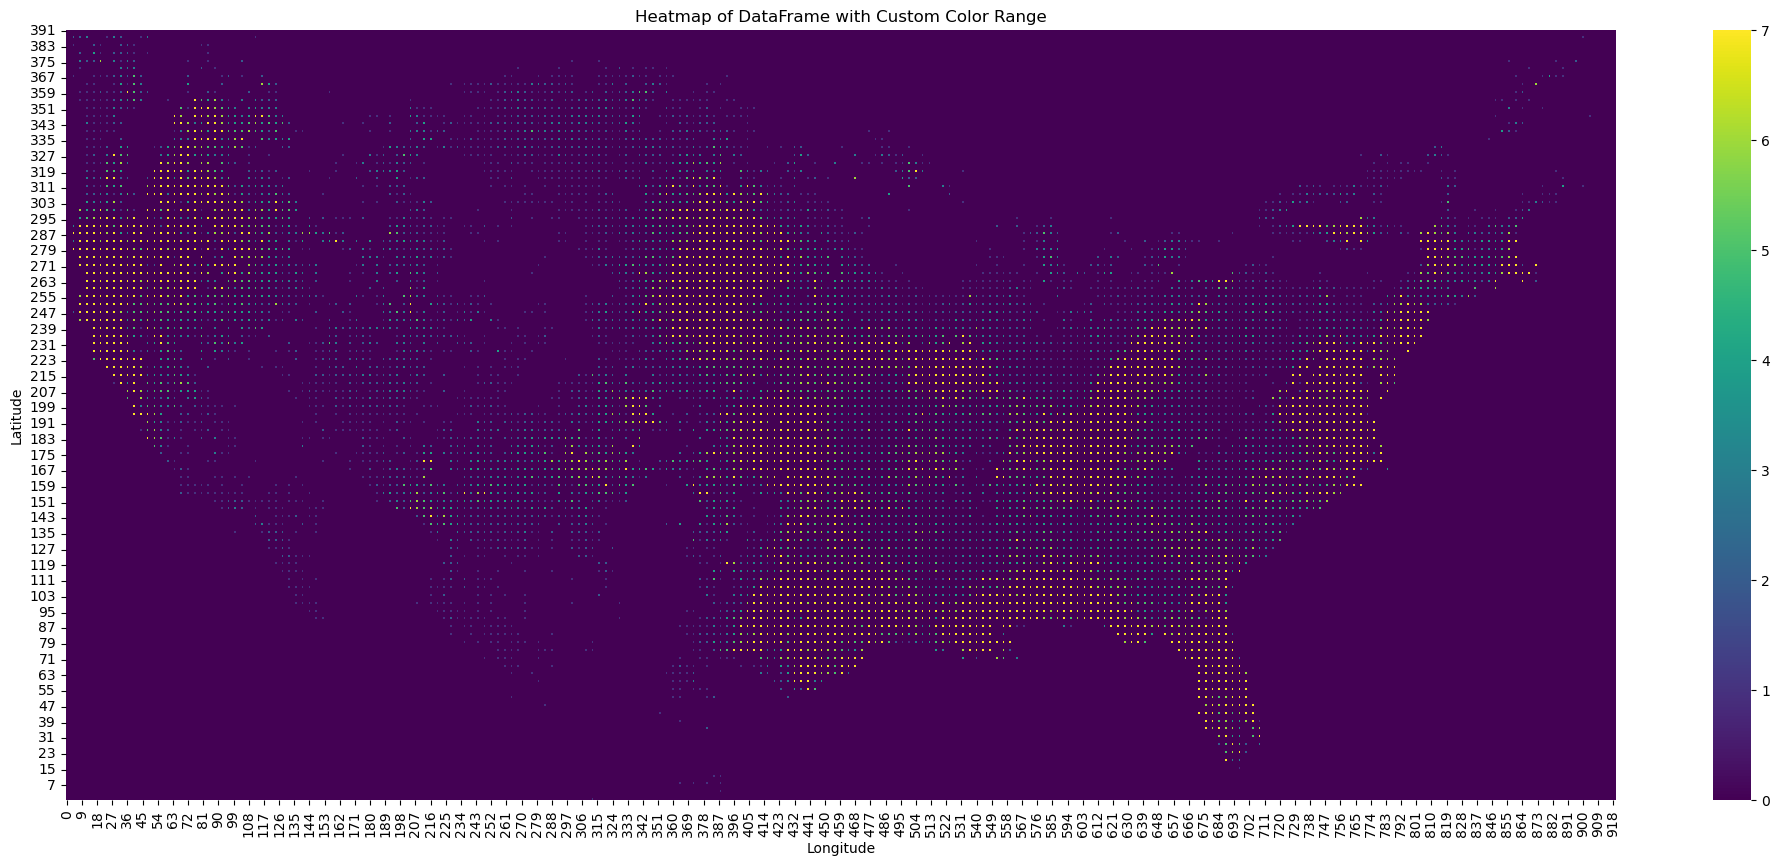

The largest number in the data is: 7


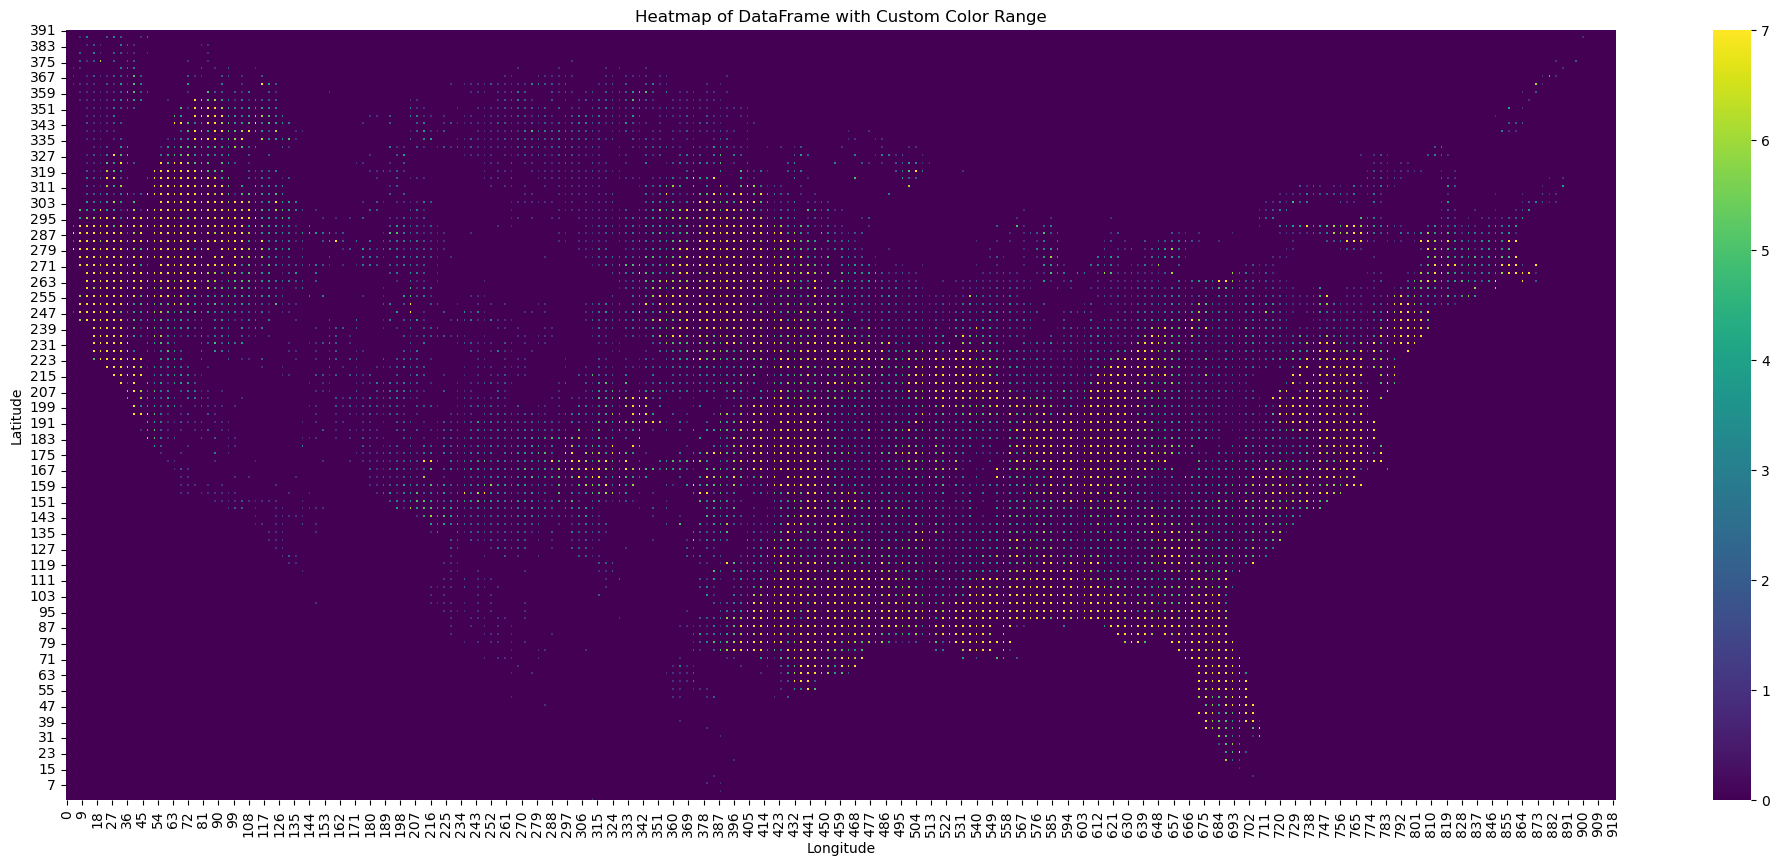

The largest number in the data is: 7


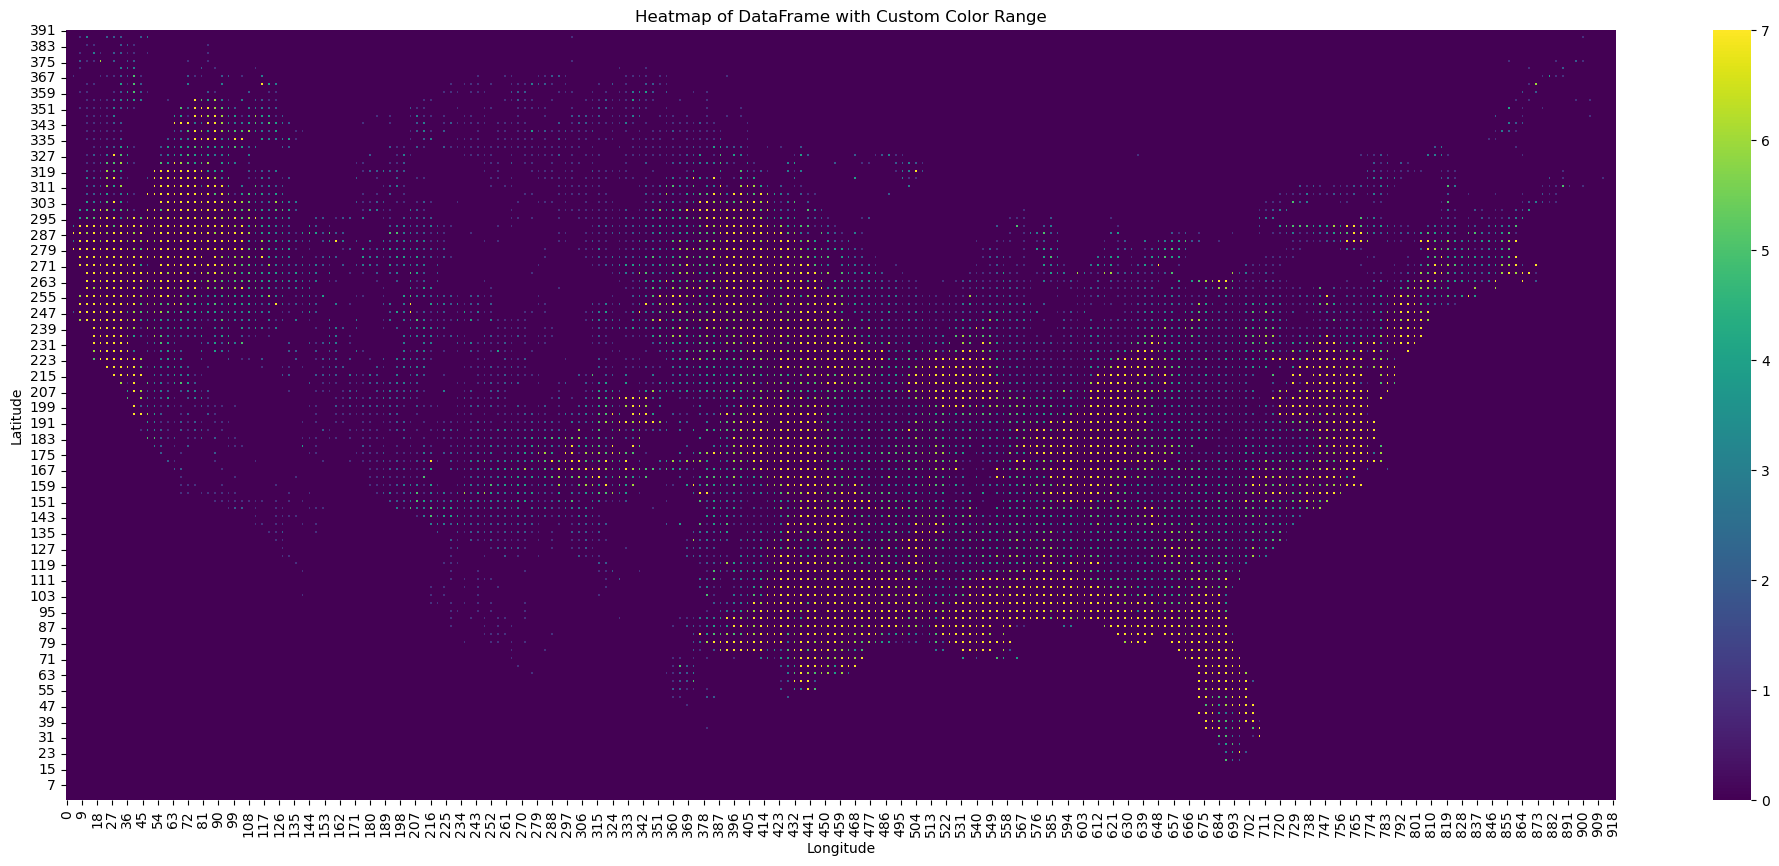

The largest number in the data is: 7


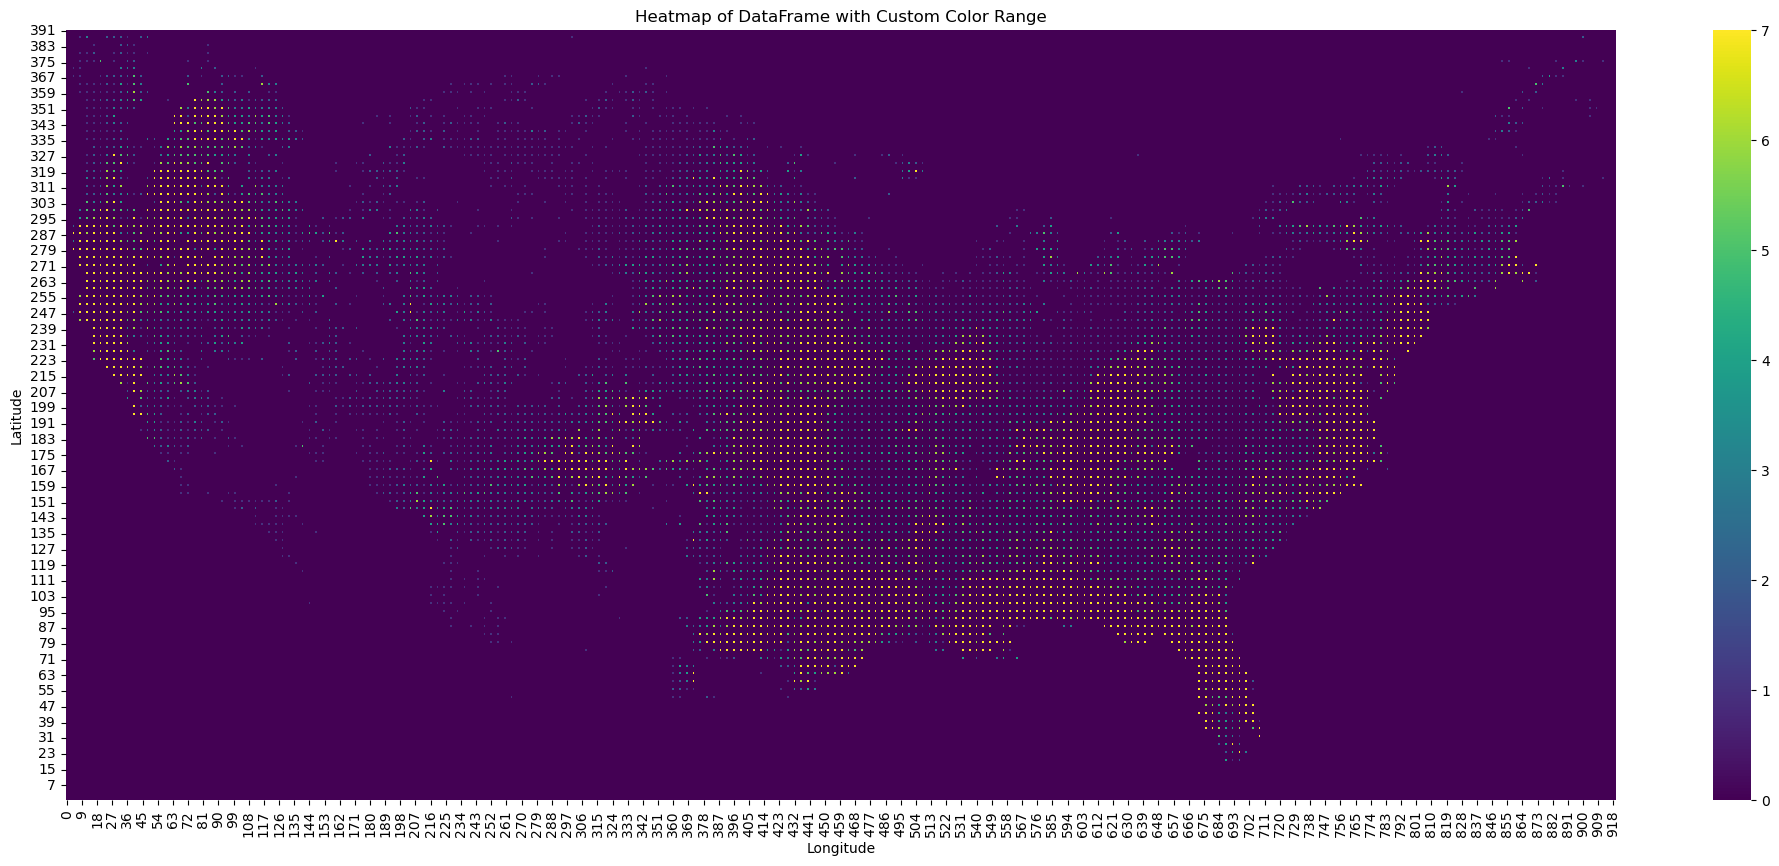

The largest number in the data is: 7


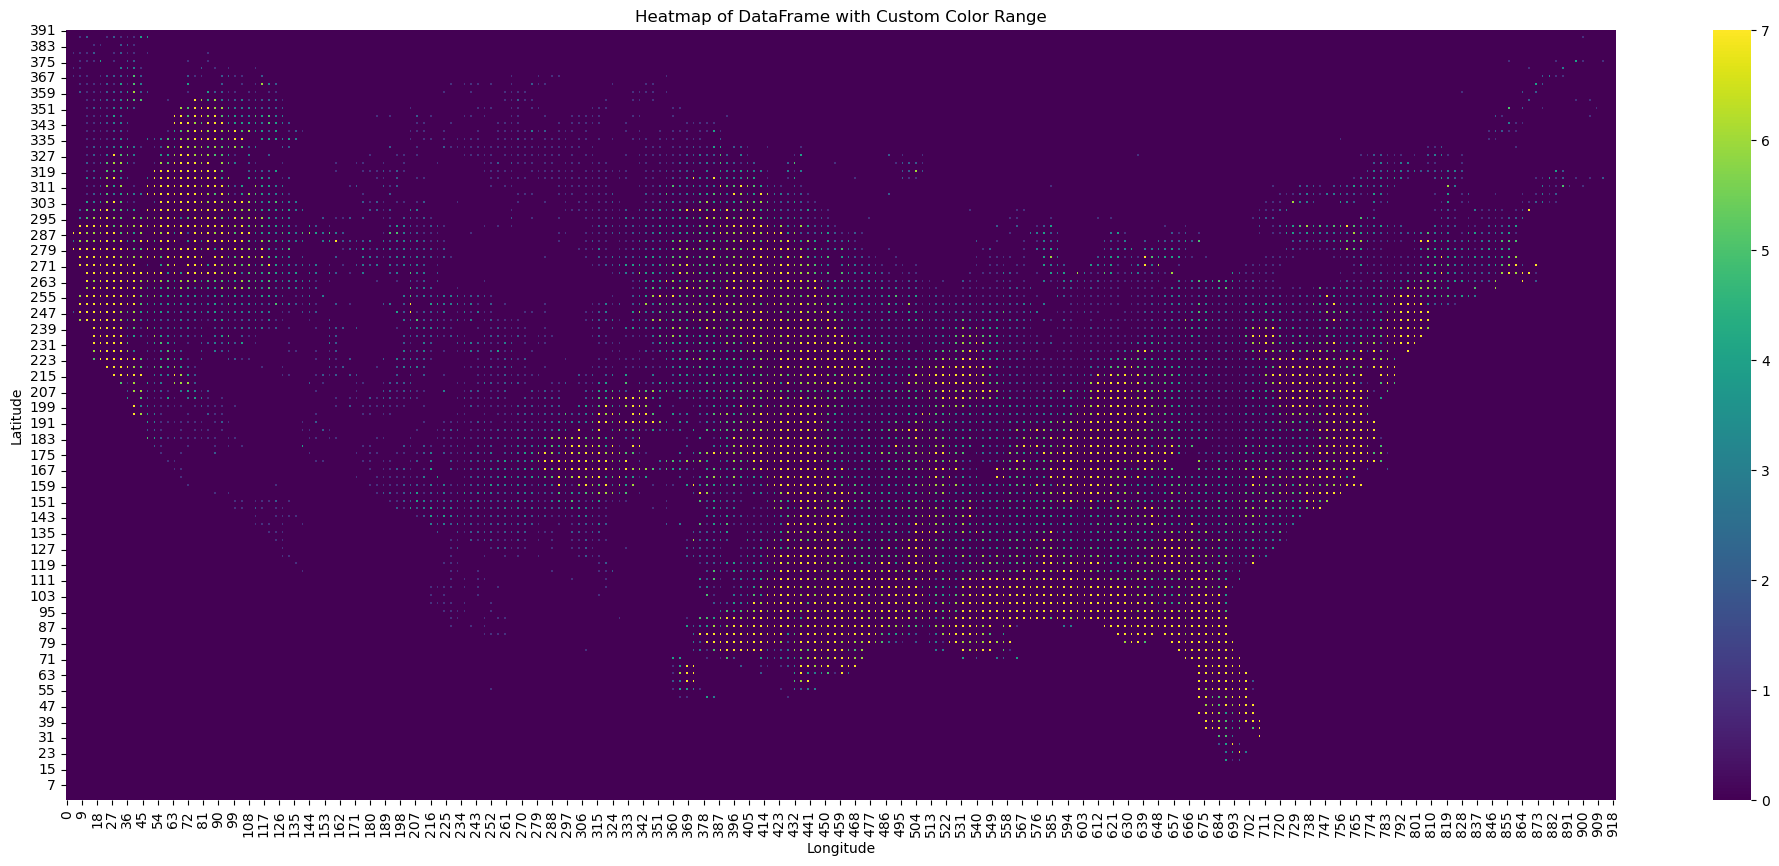

The largest number in the data is: 7


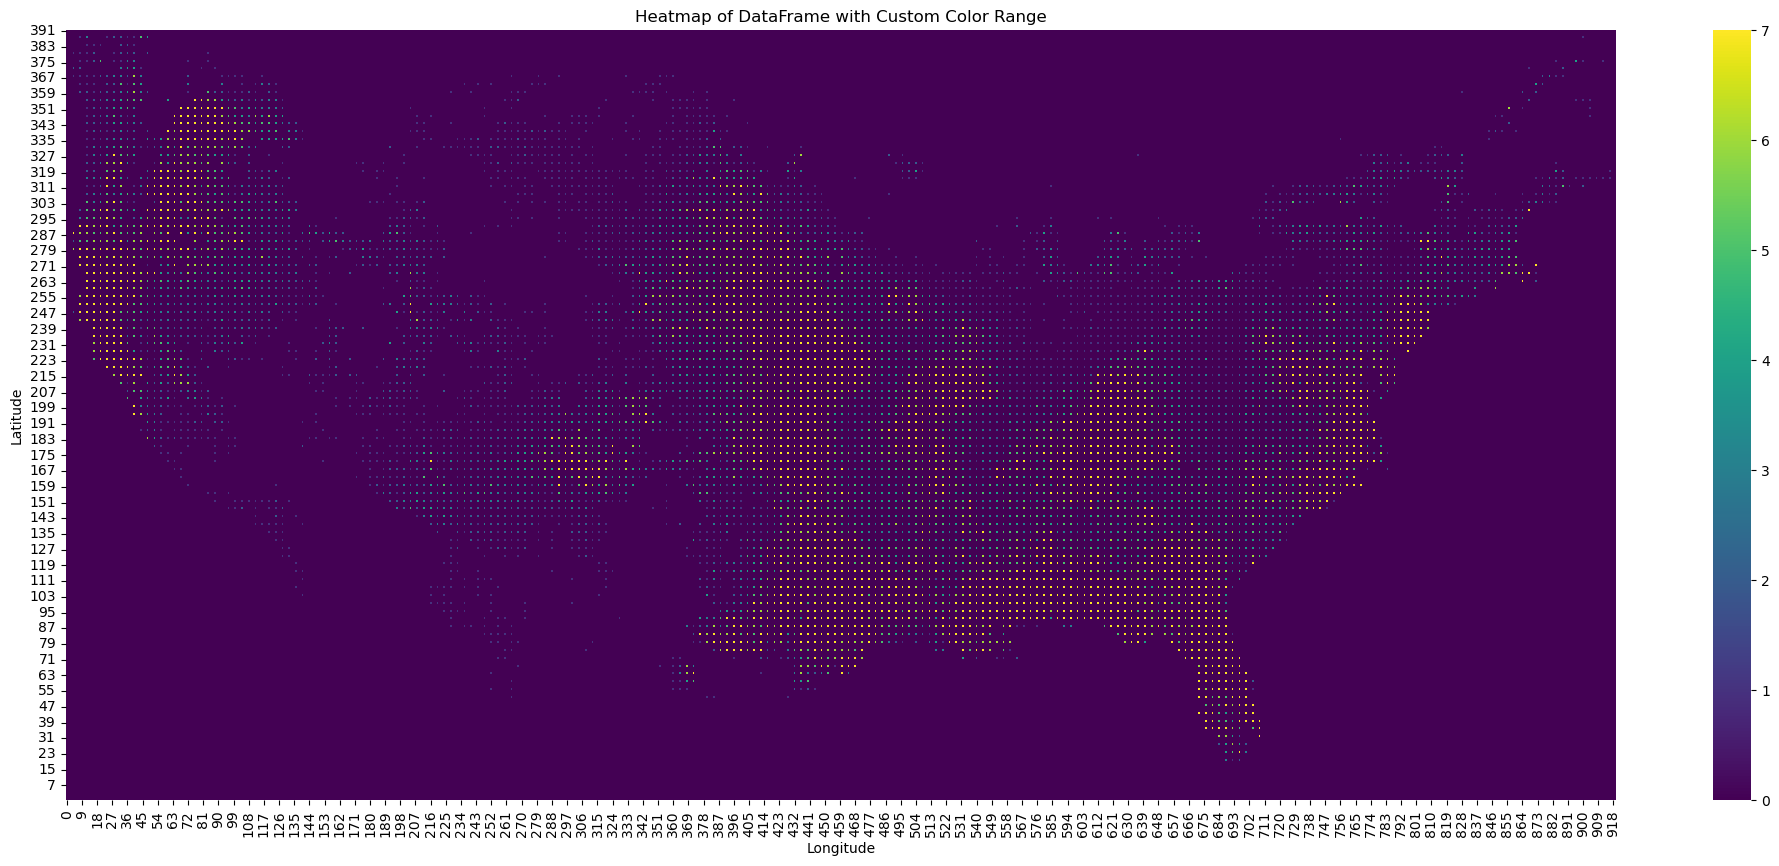

The largest number in the data is: 7


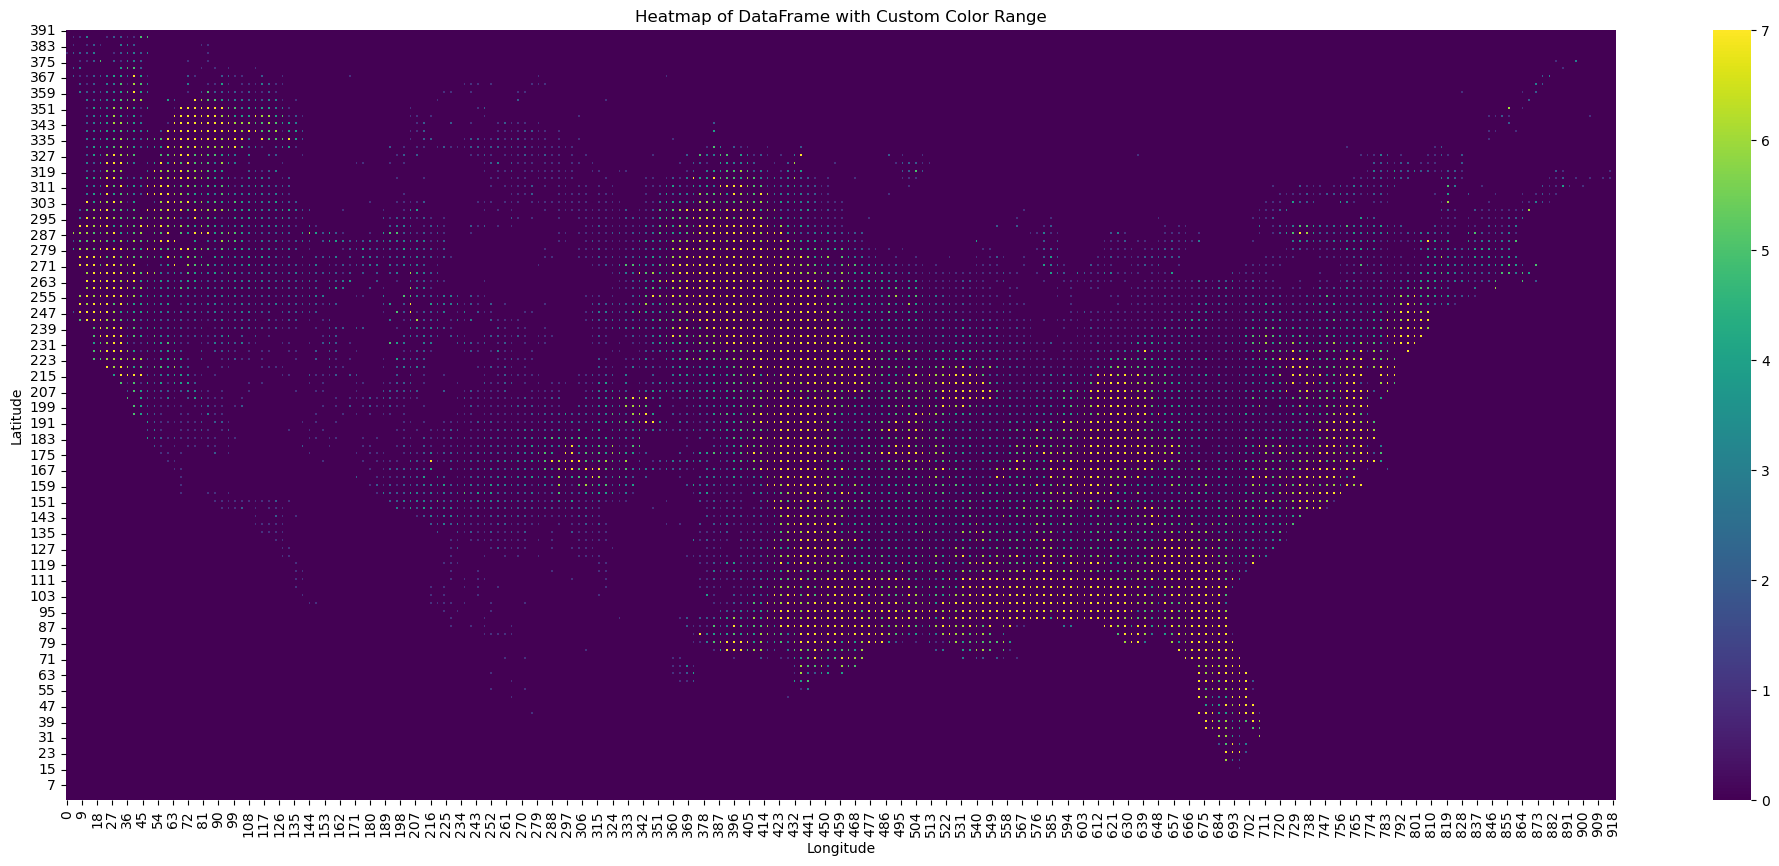

The largest number in the data is: 7


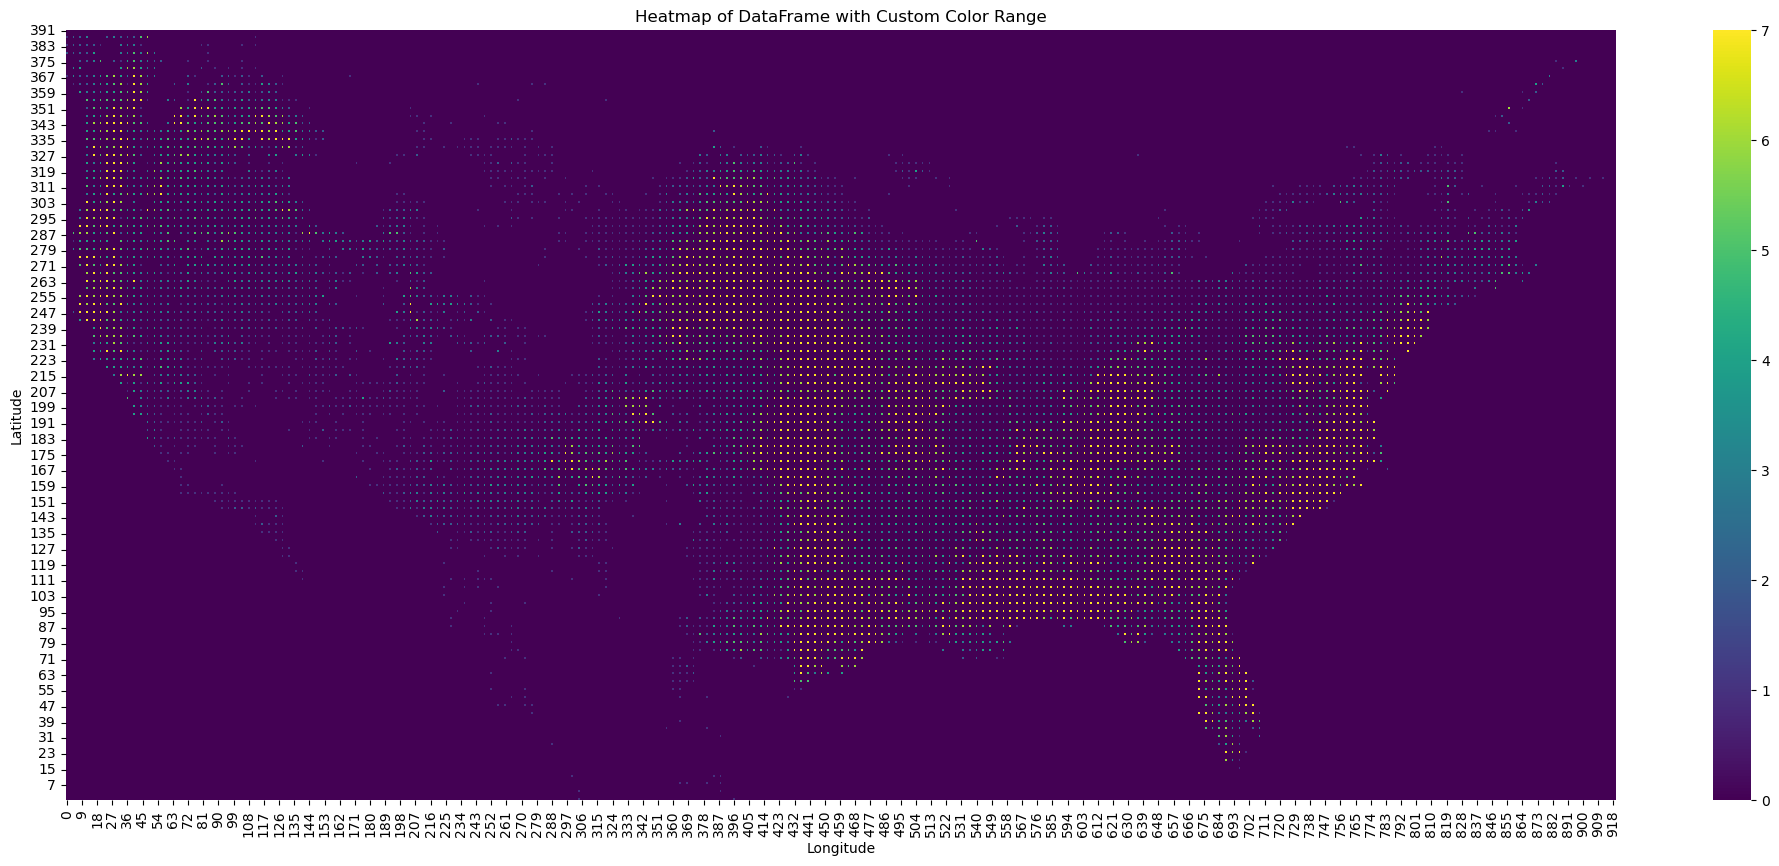

The largest number in the data is: 7


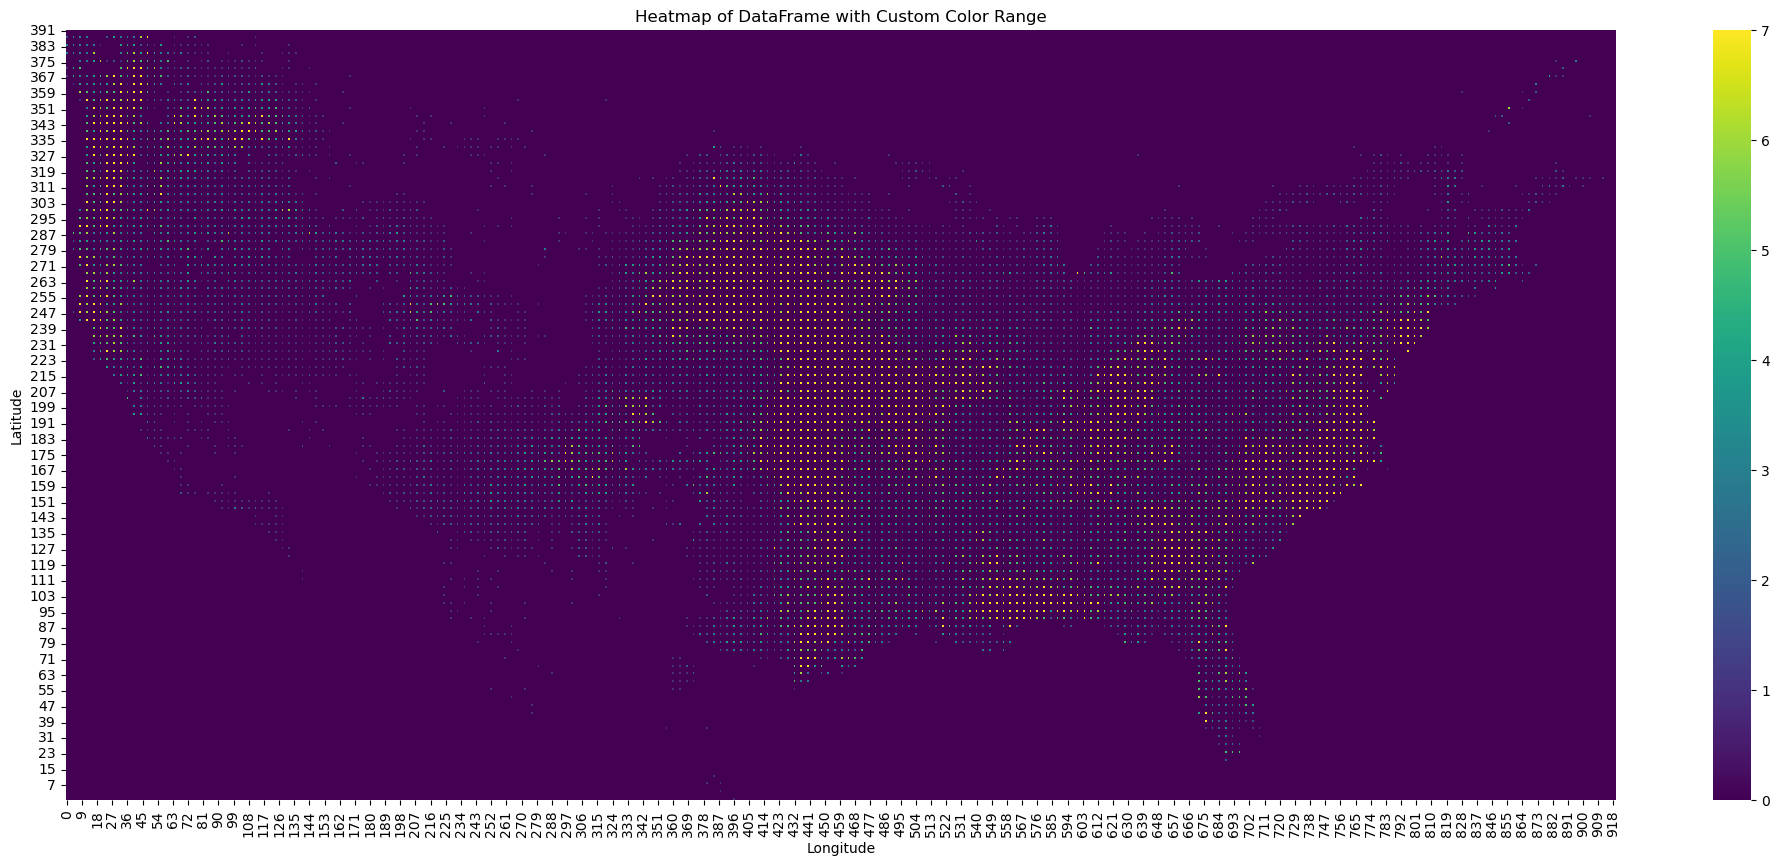

The largest number in the data is: 7


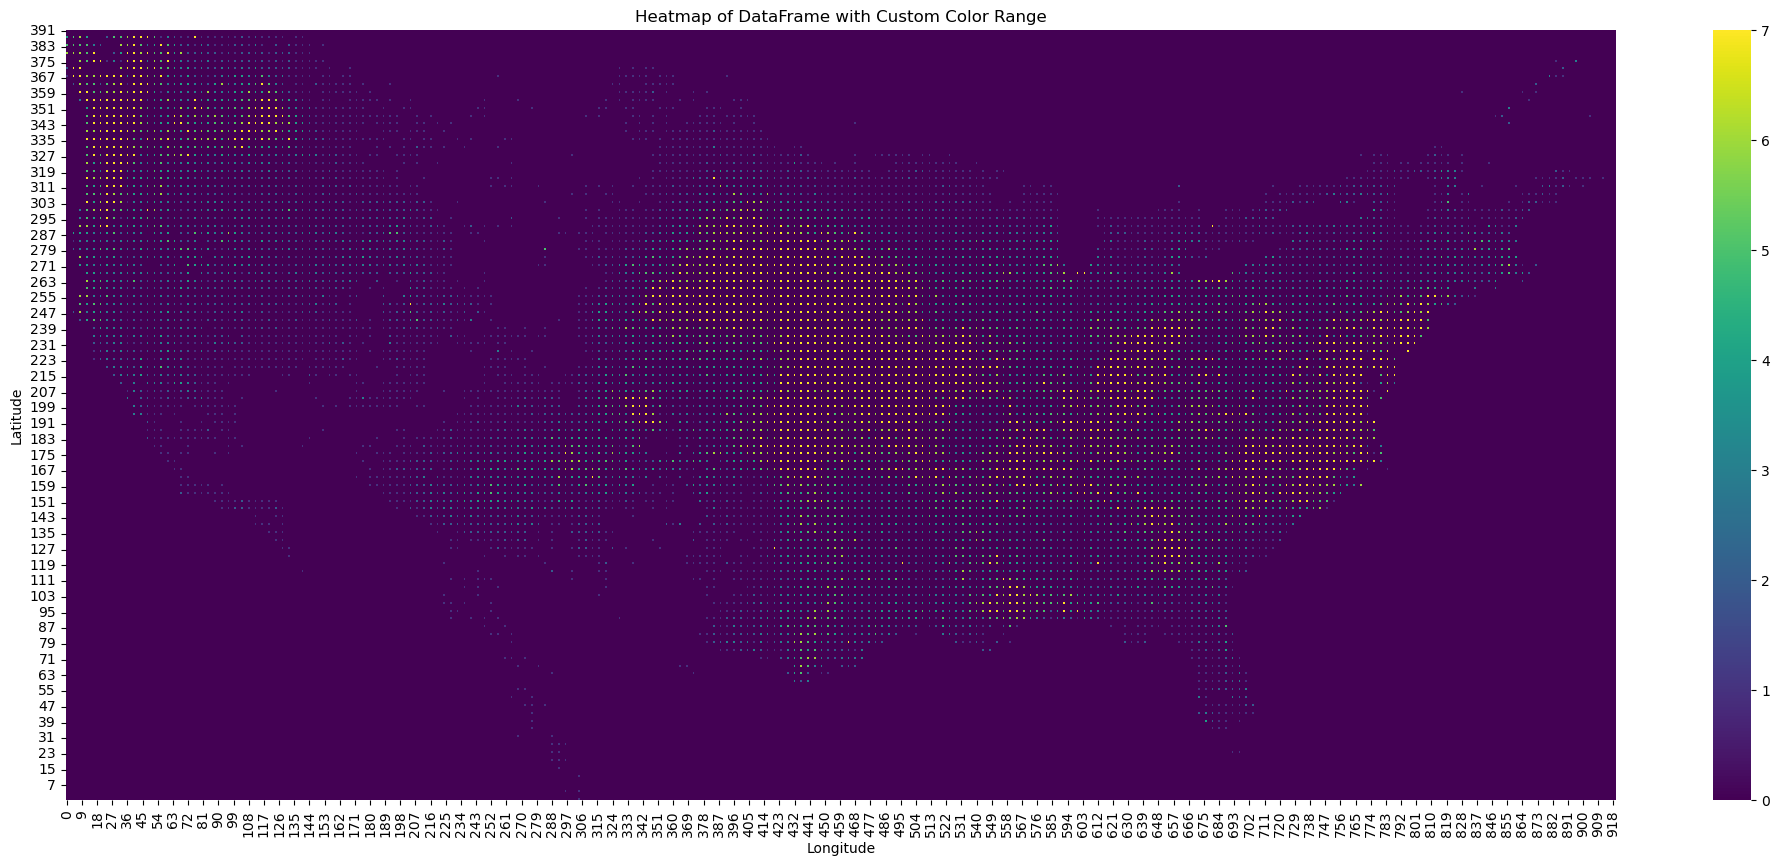

The largest number in the data is: 7


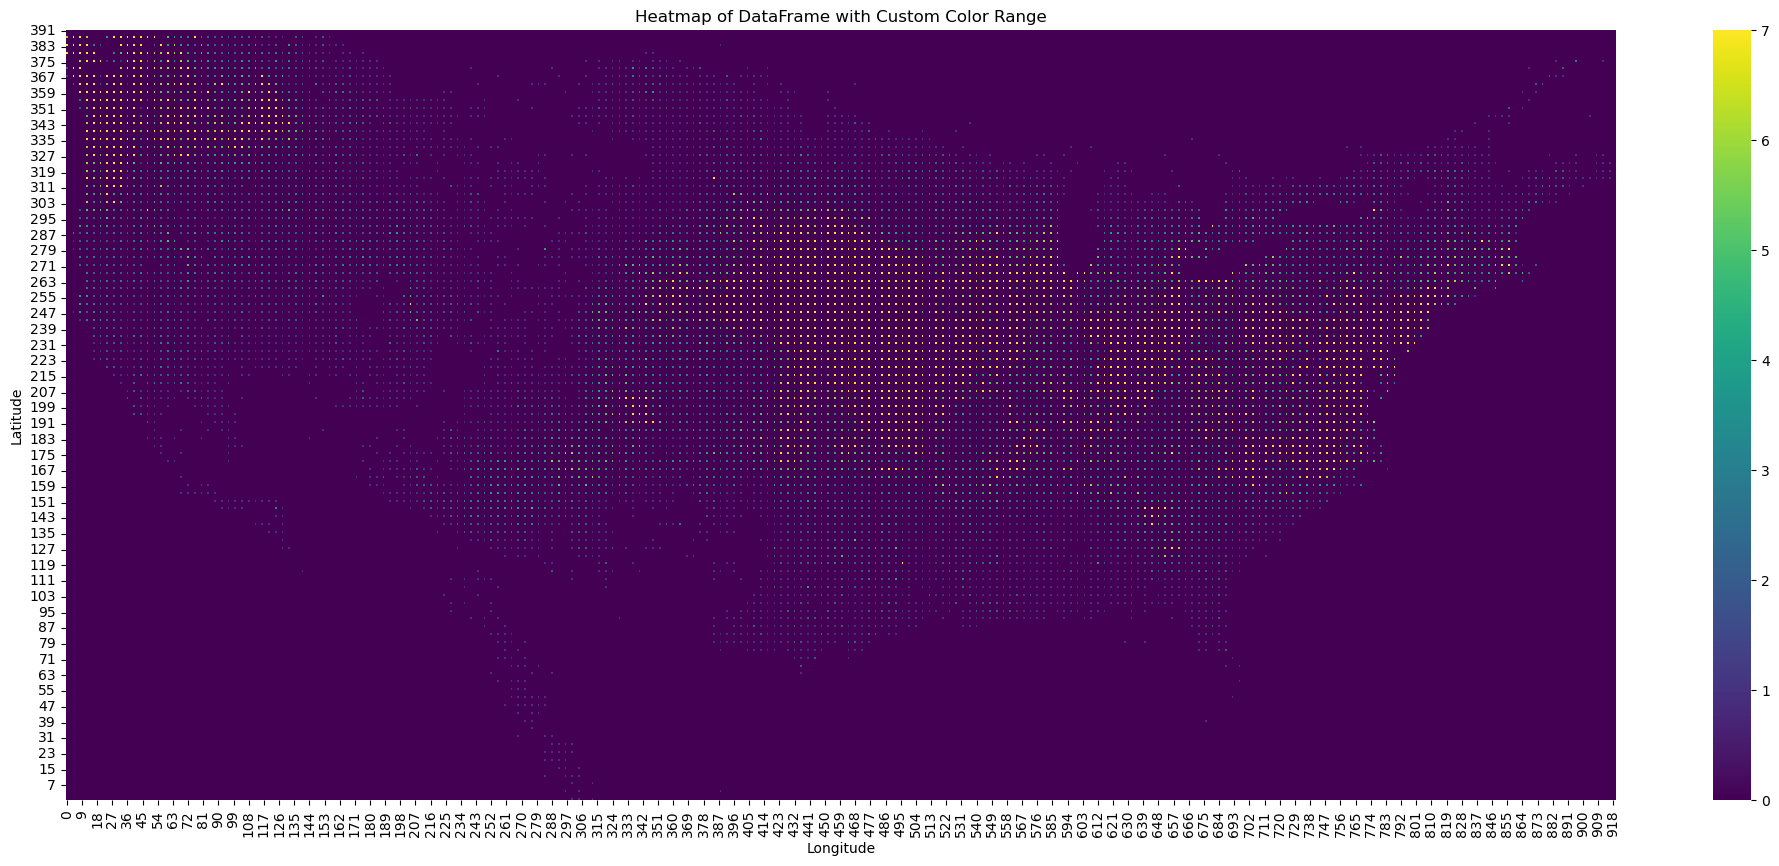

The largest number in the data is: 7


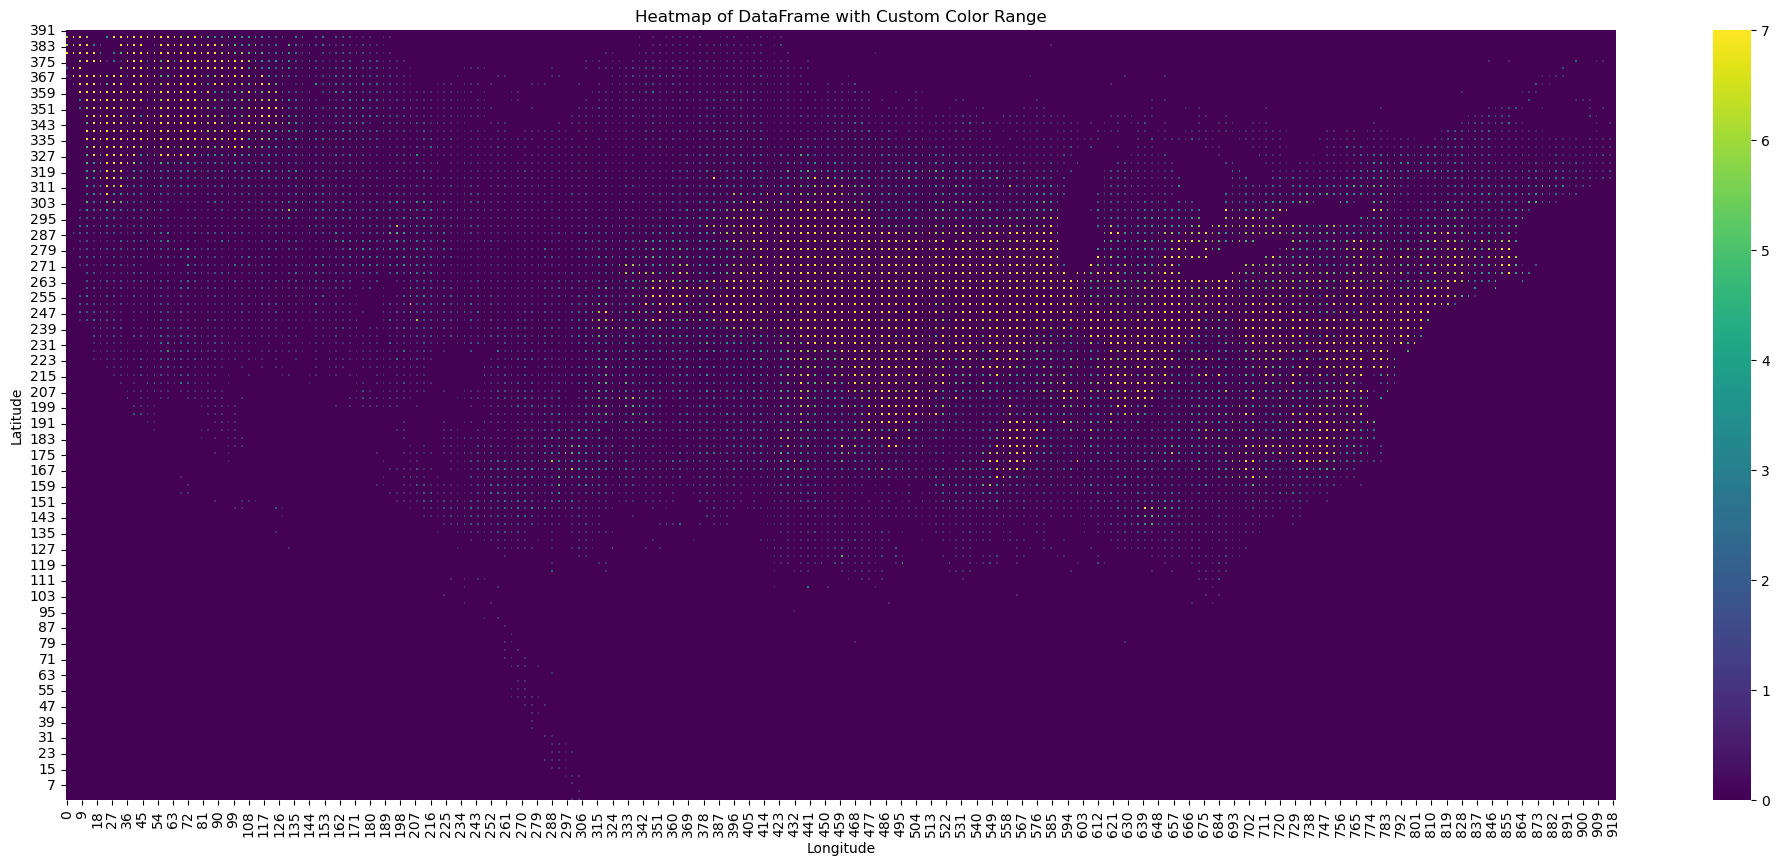

The largest number in the data is: 7


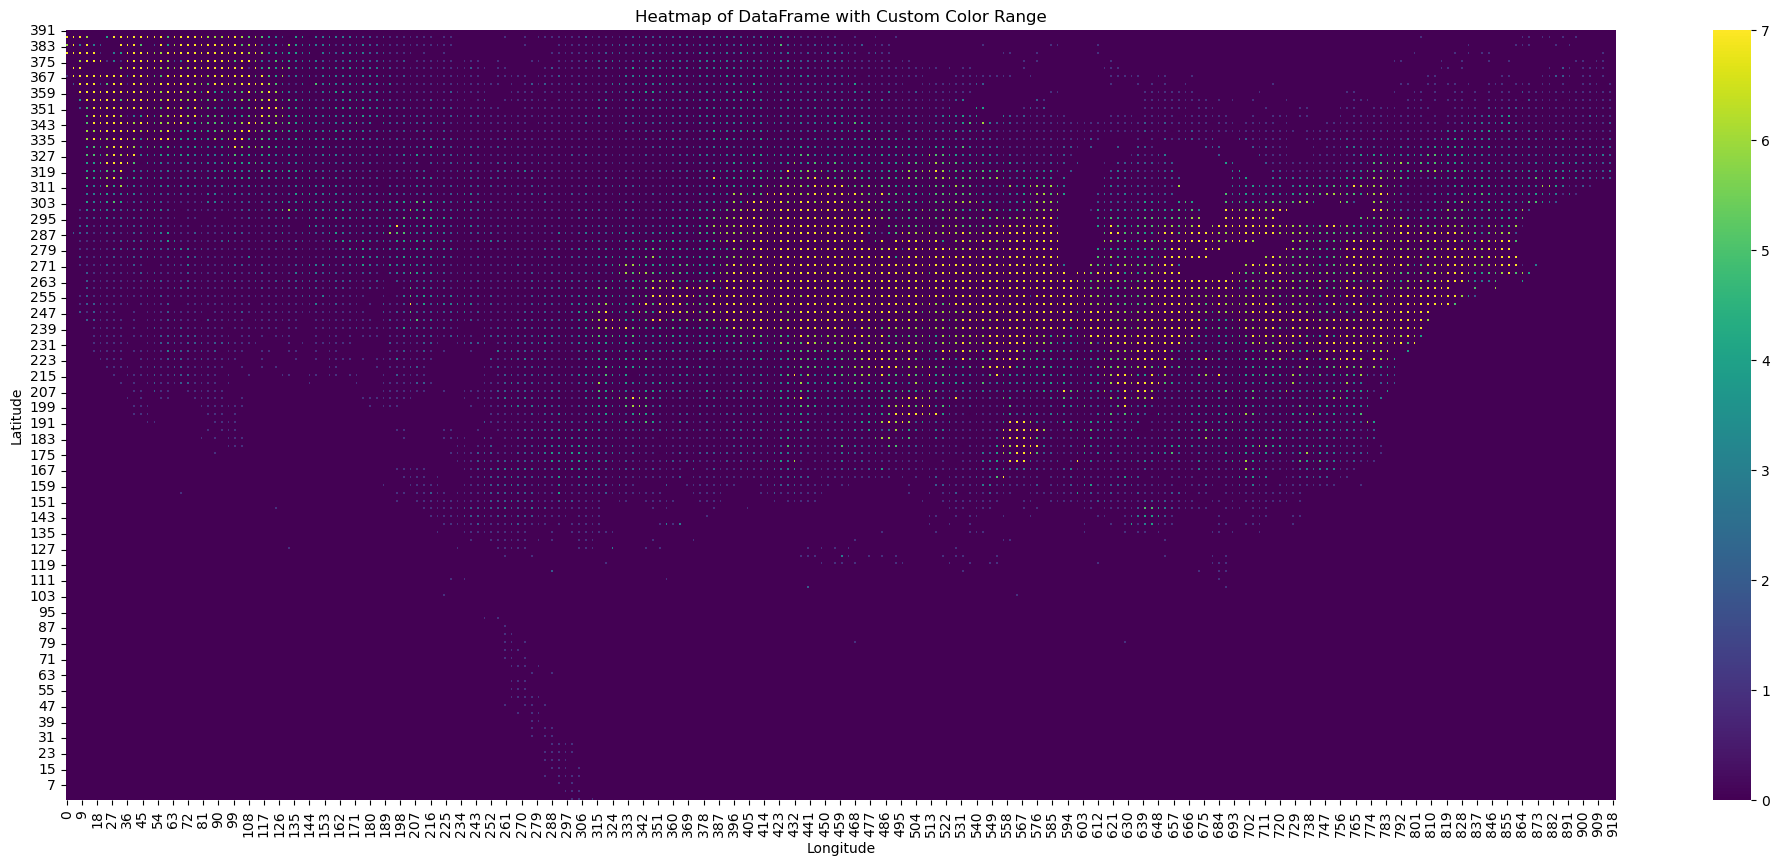

The largest number in the data is: 7


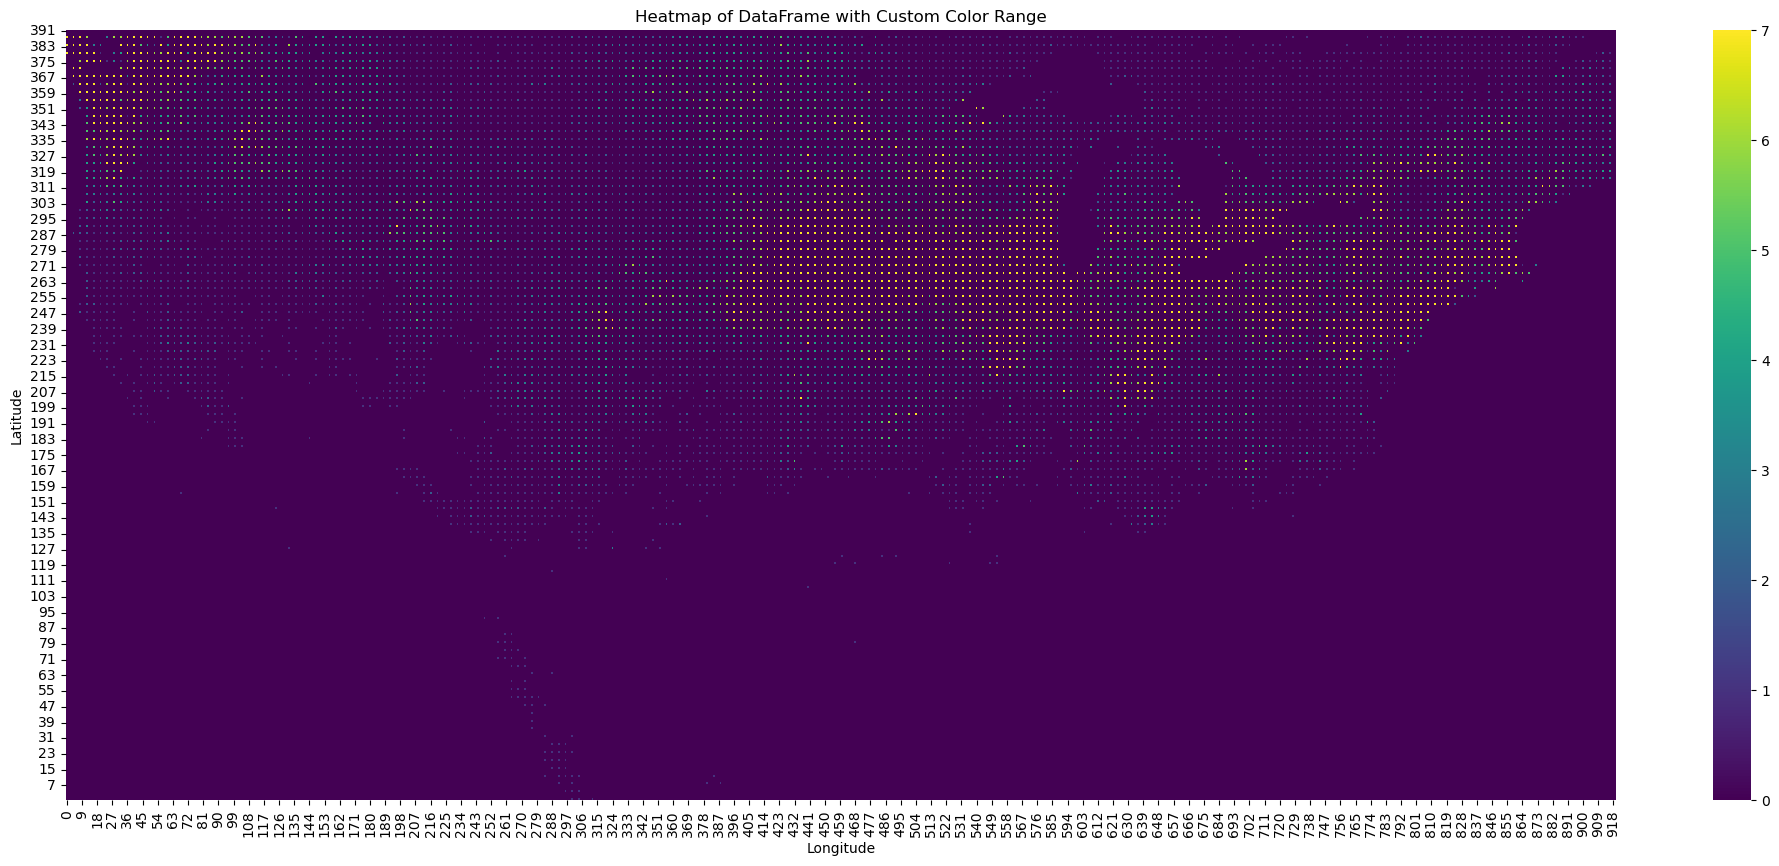

The largest number in the data is: 7


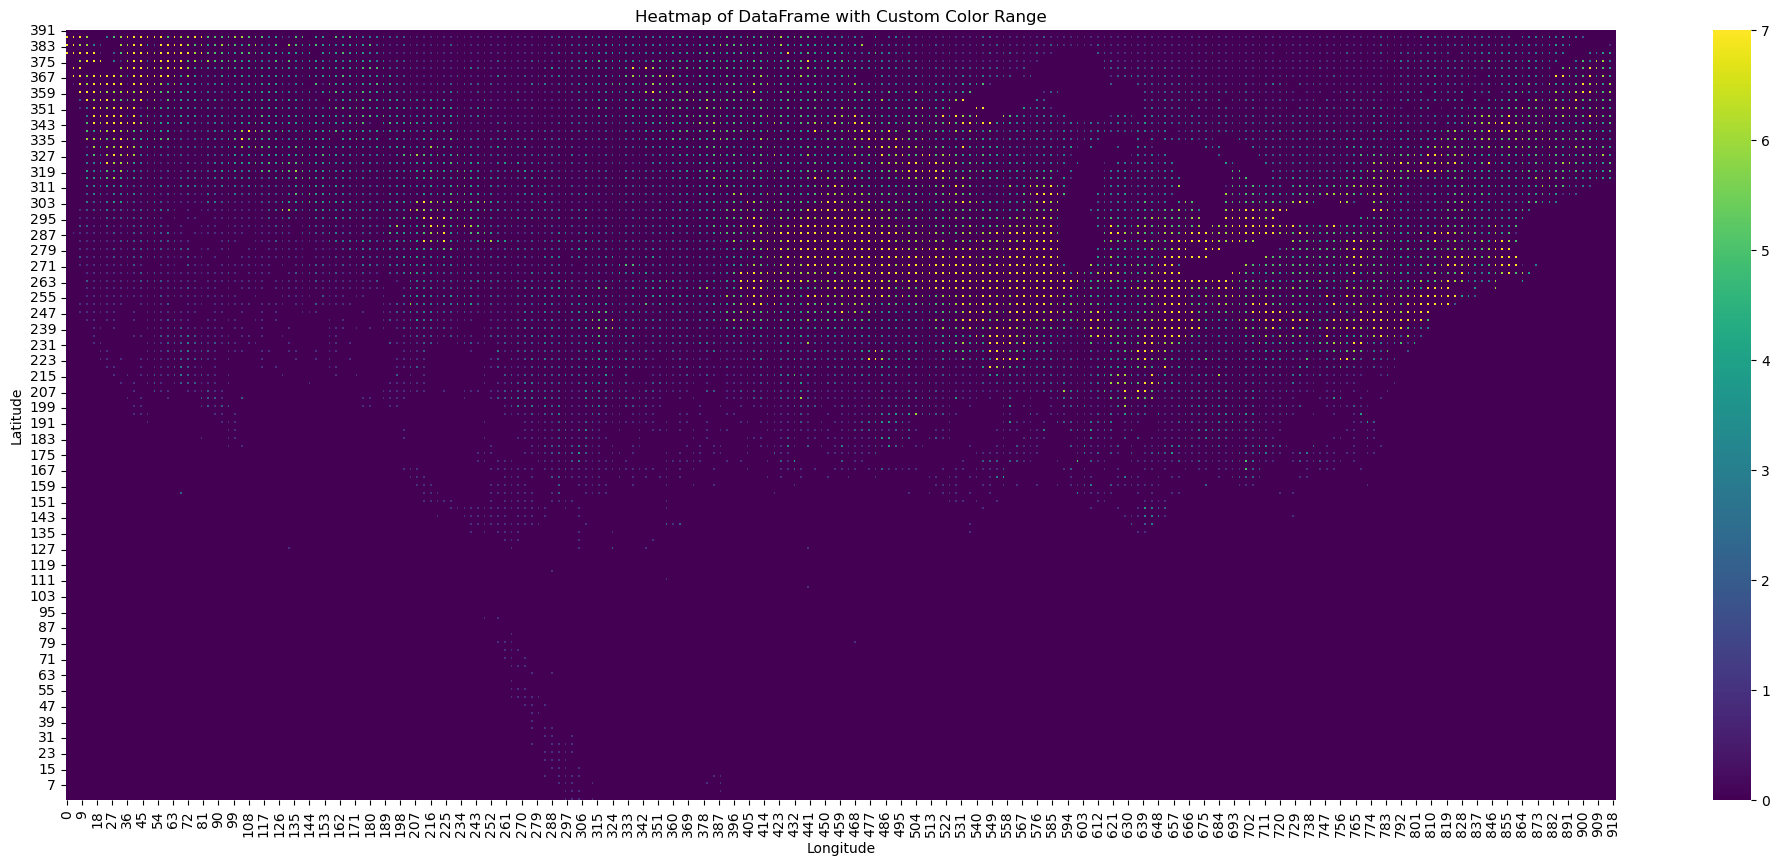

The largest number in the data is: 7


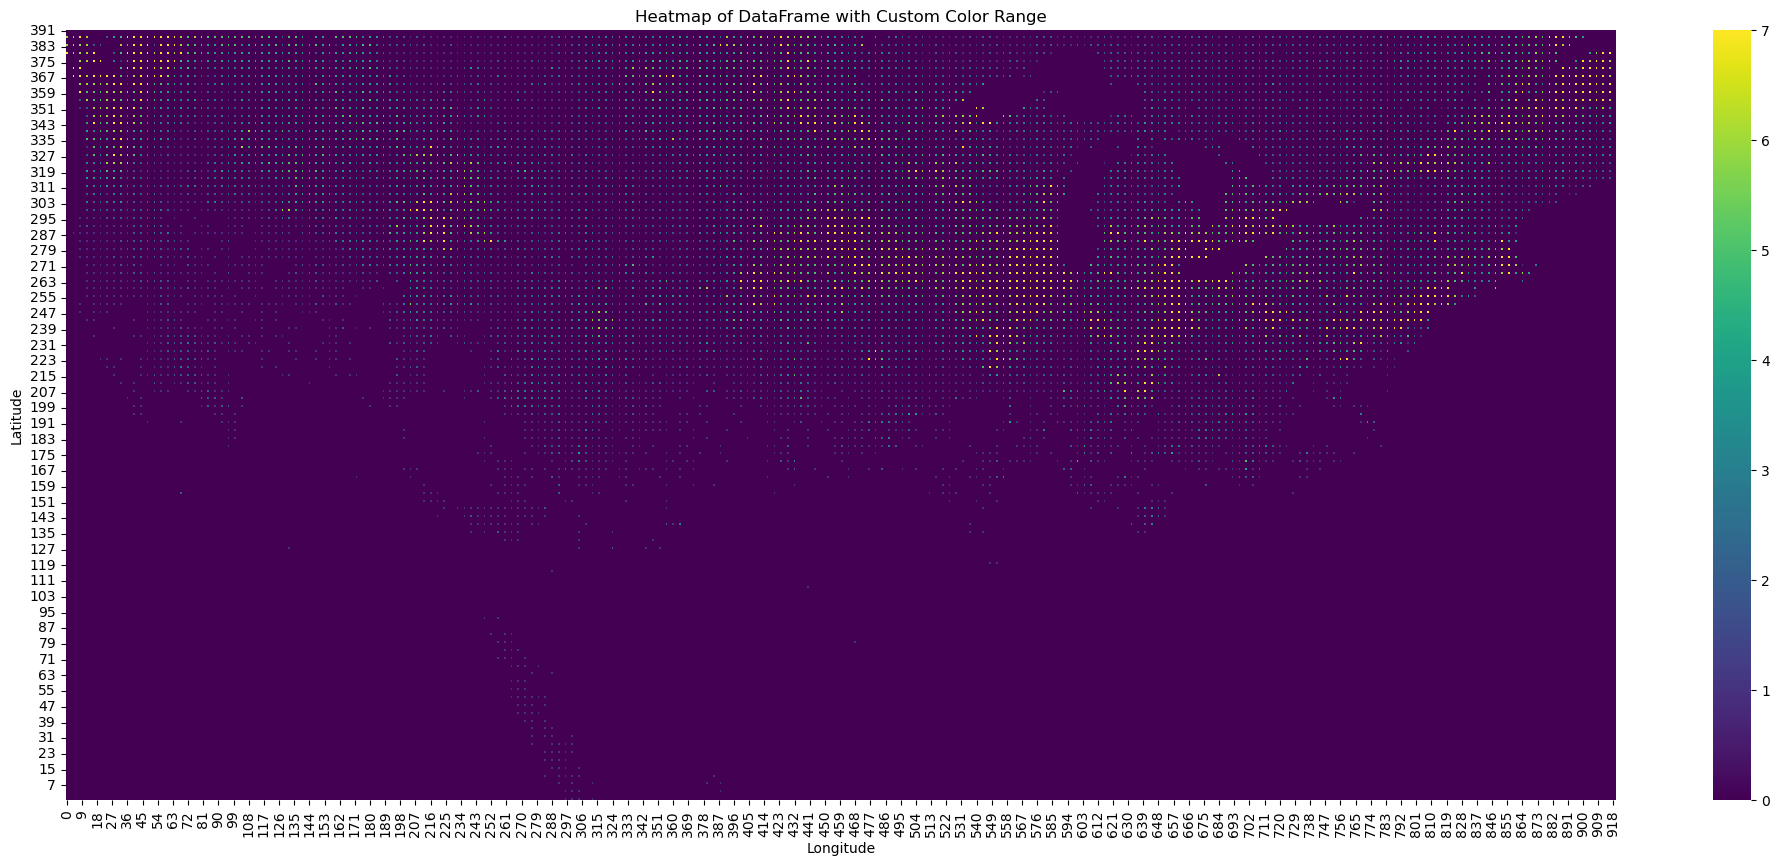

The largest number in the data is: 7


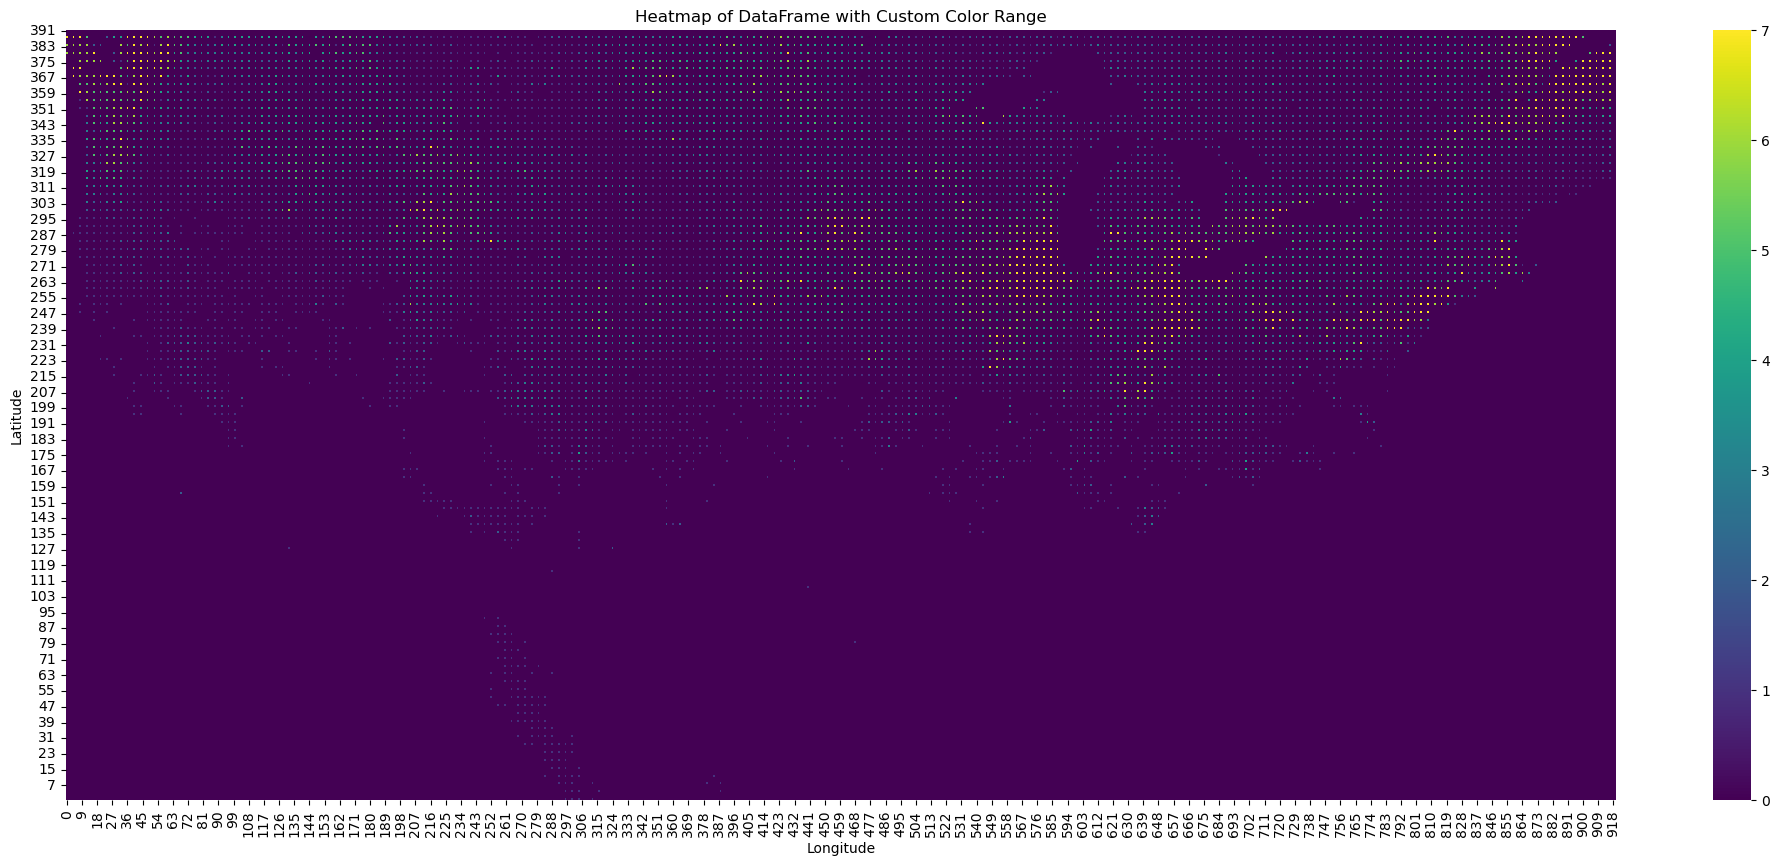

The largest number in the data is: 7


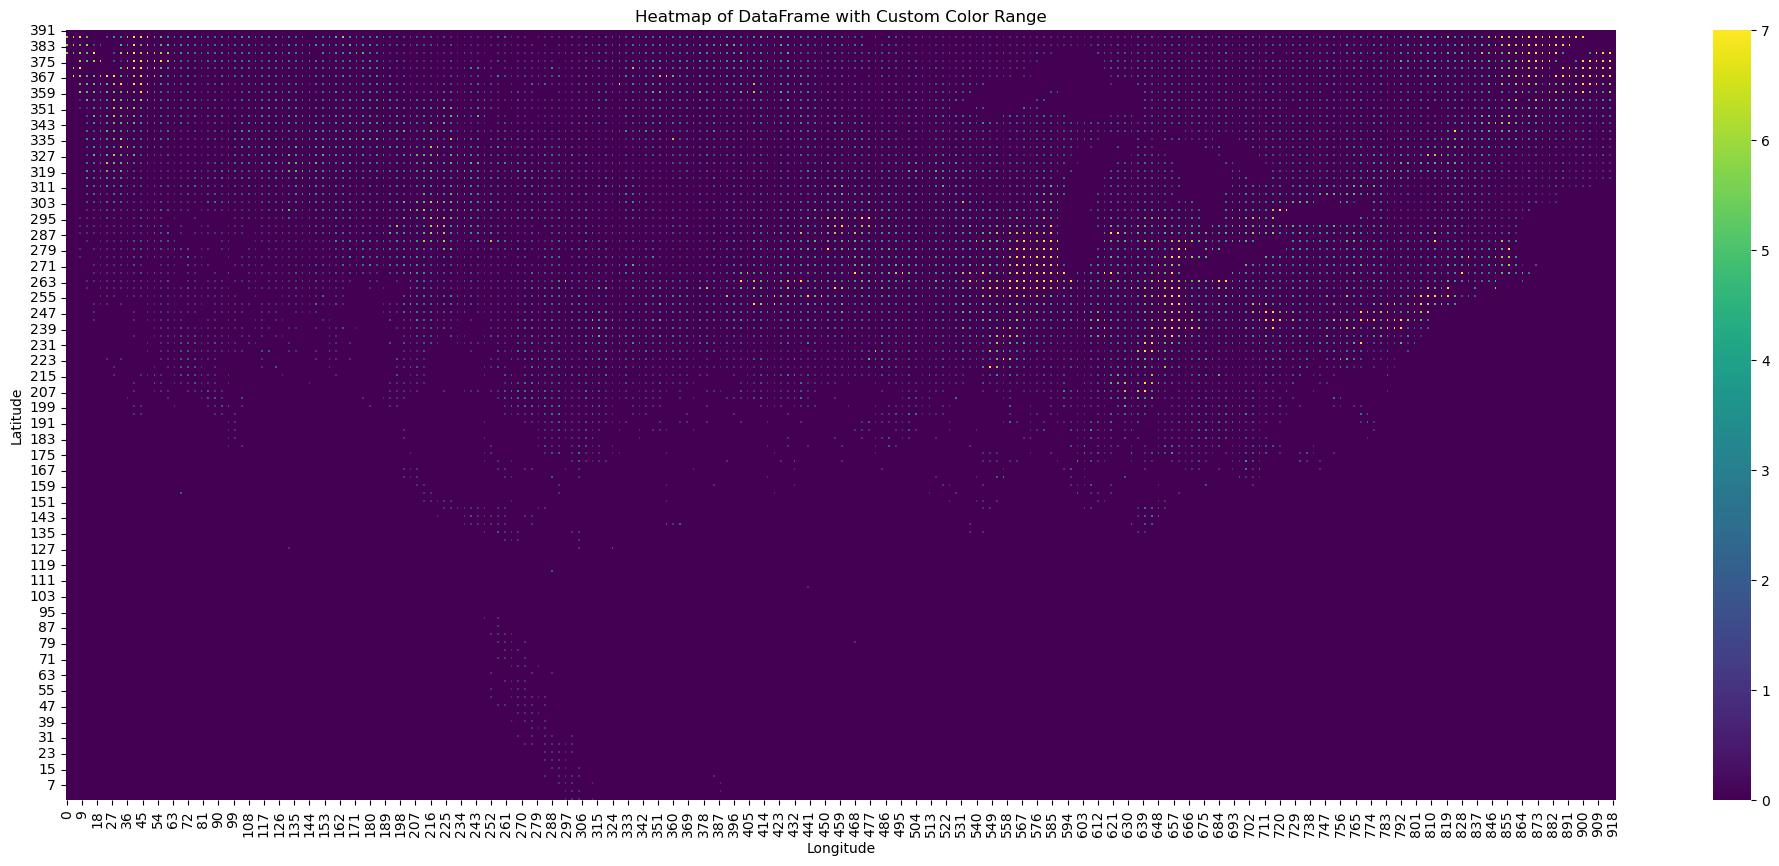

The largest number in the data is: 7


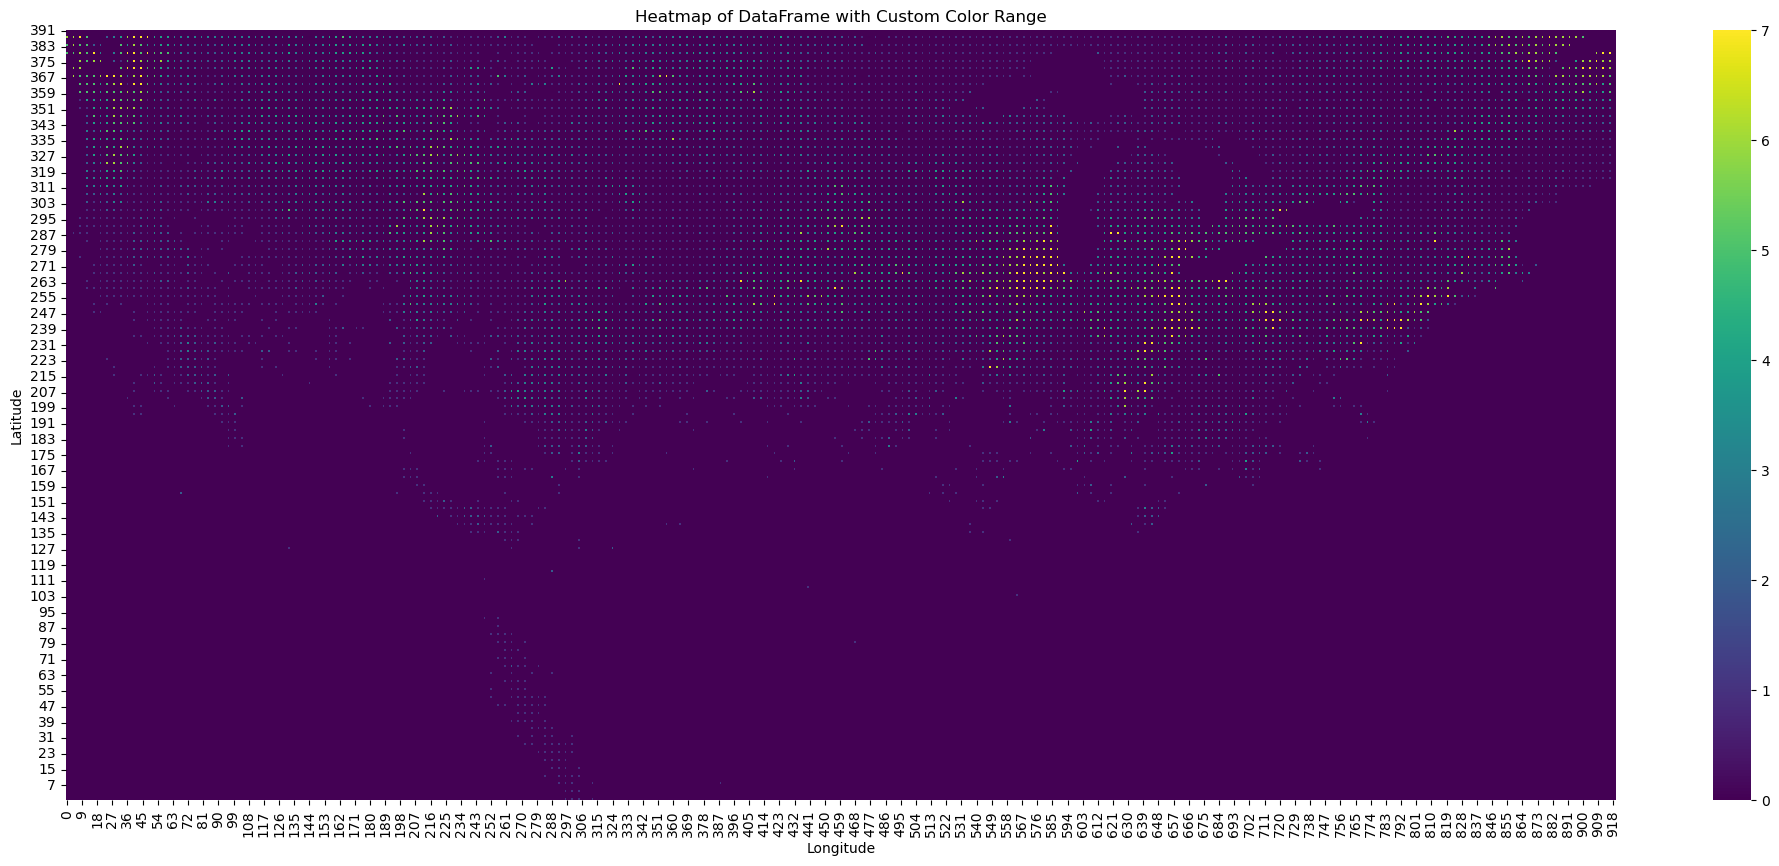

The largest number in the data is: 7


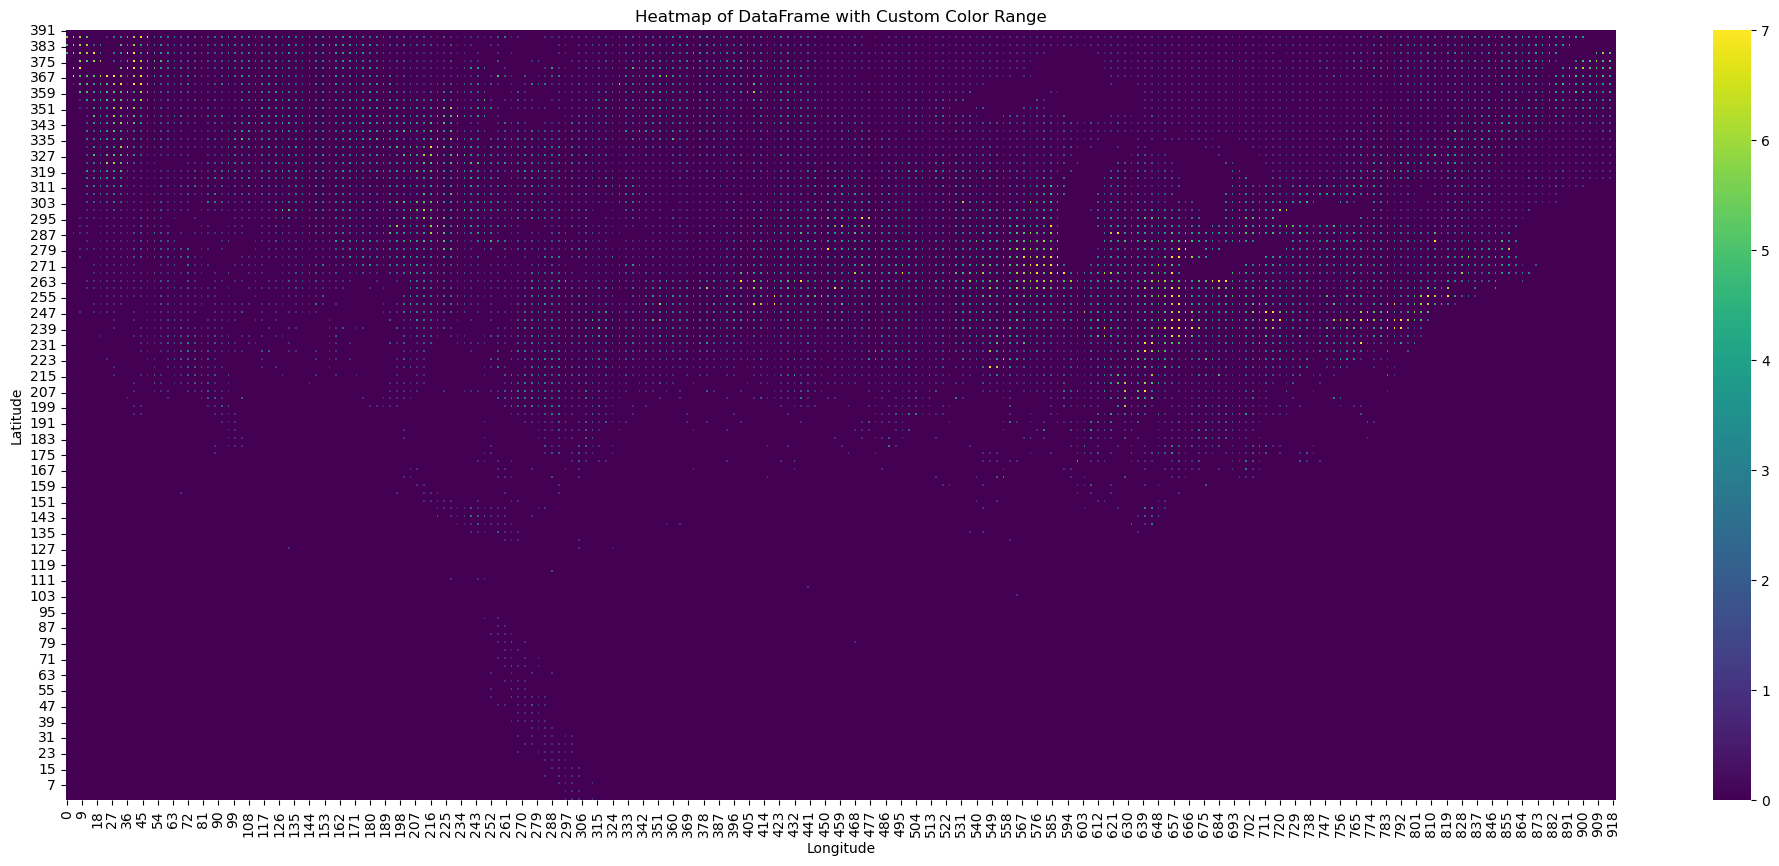

The largest number in the data is: 7


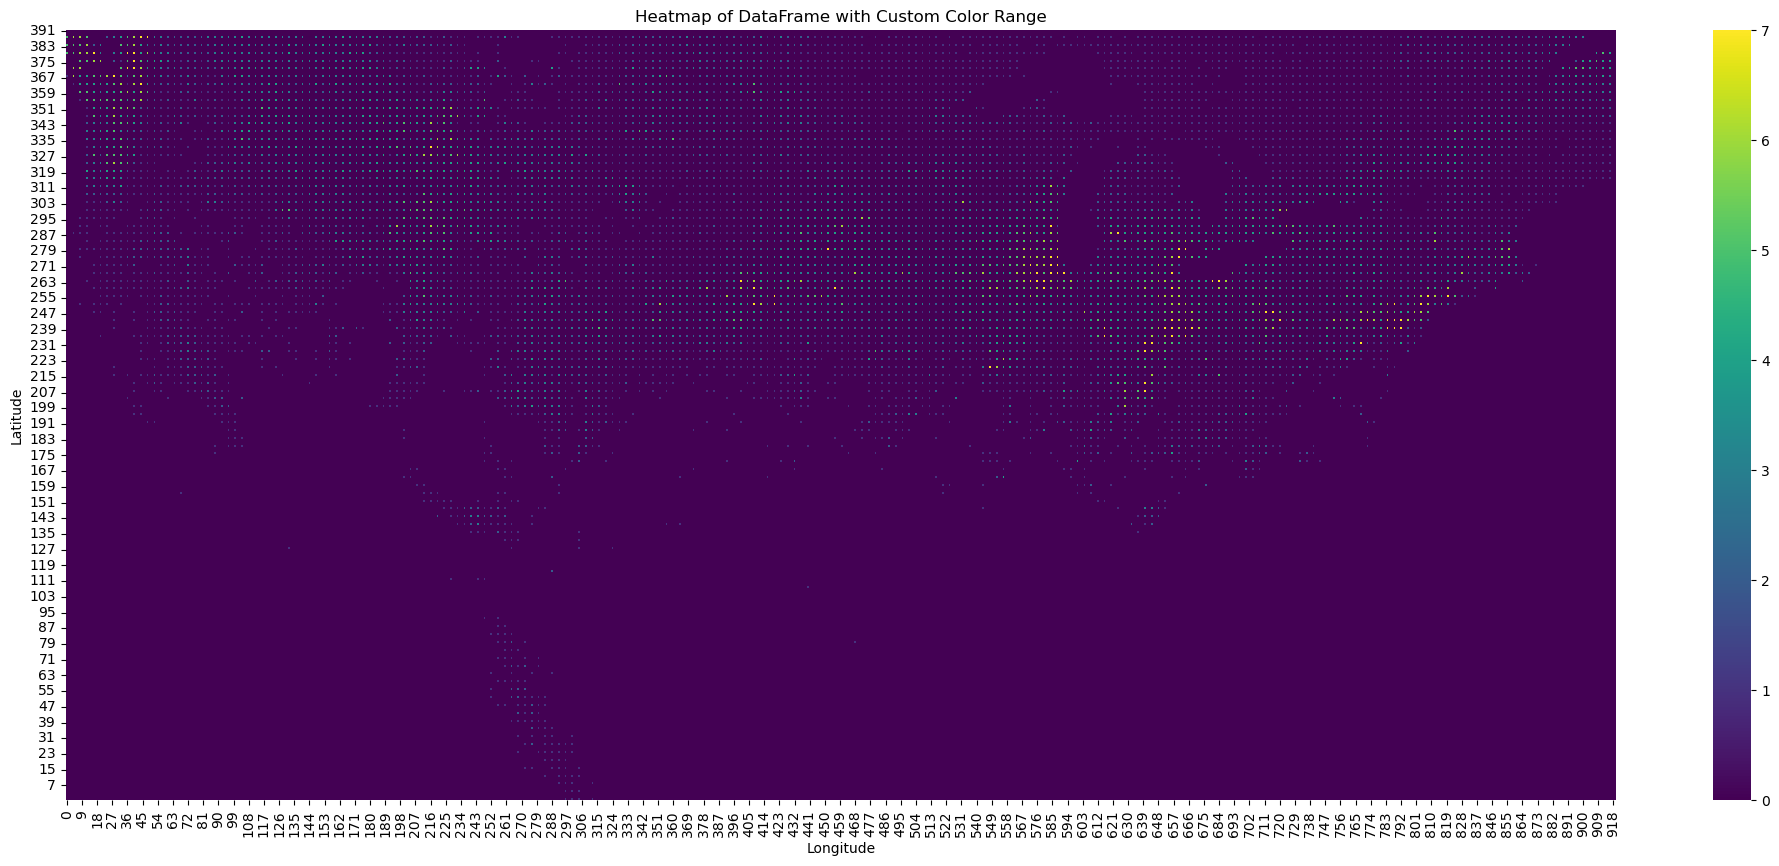

The largest number in the data is: 7


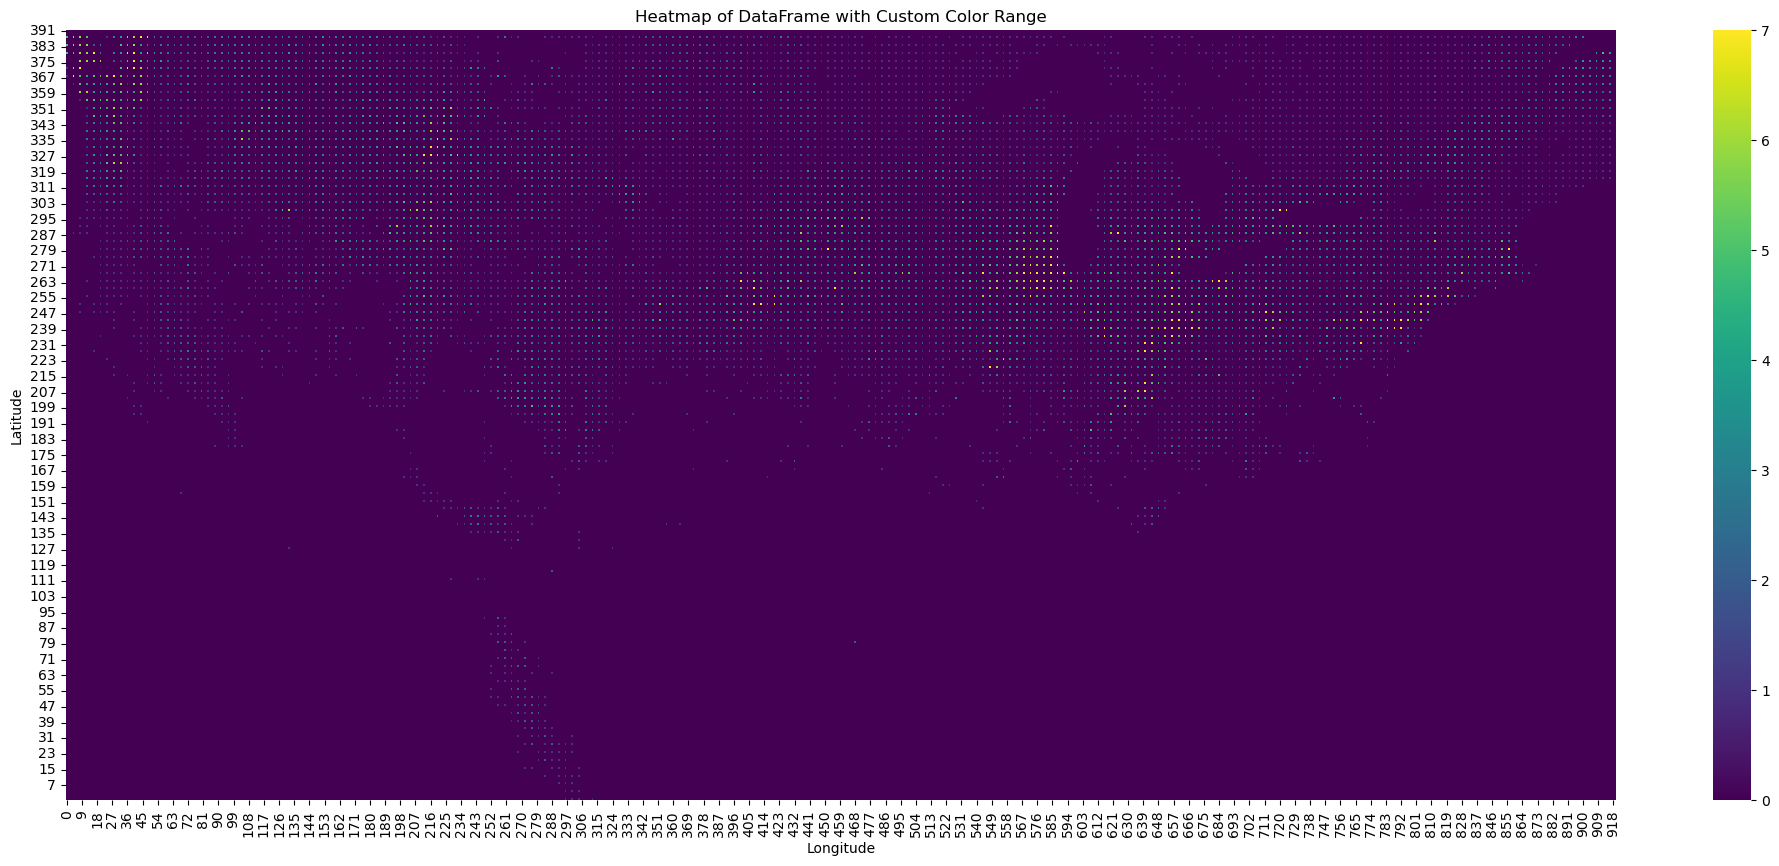

The largest number in the data is: 7


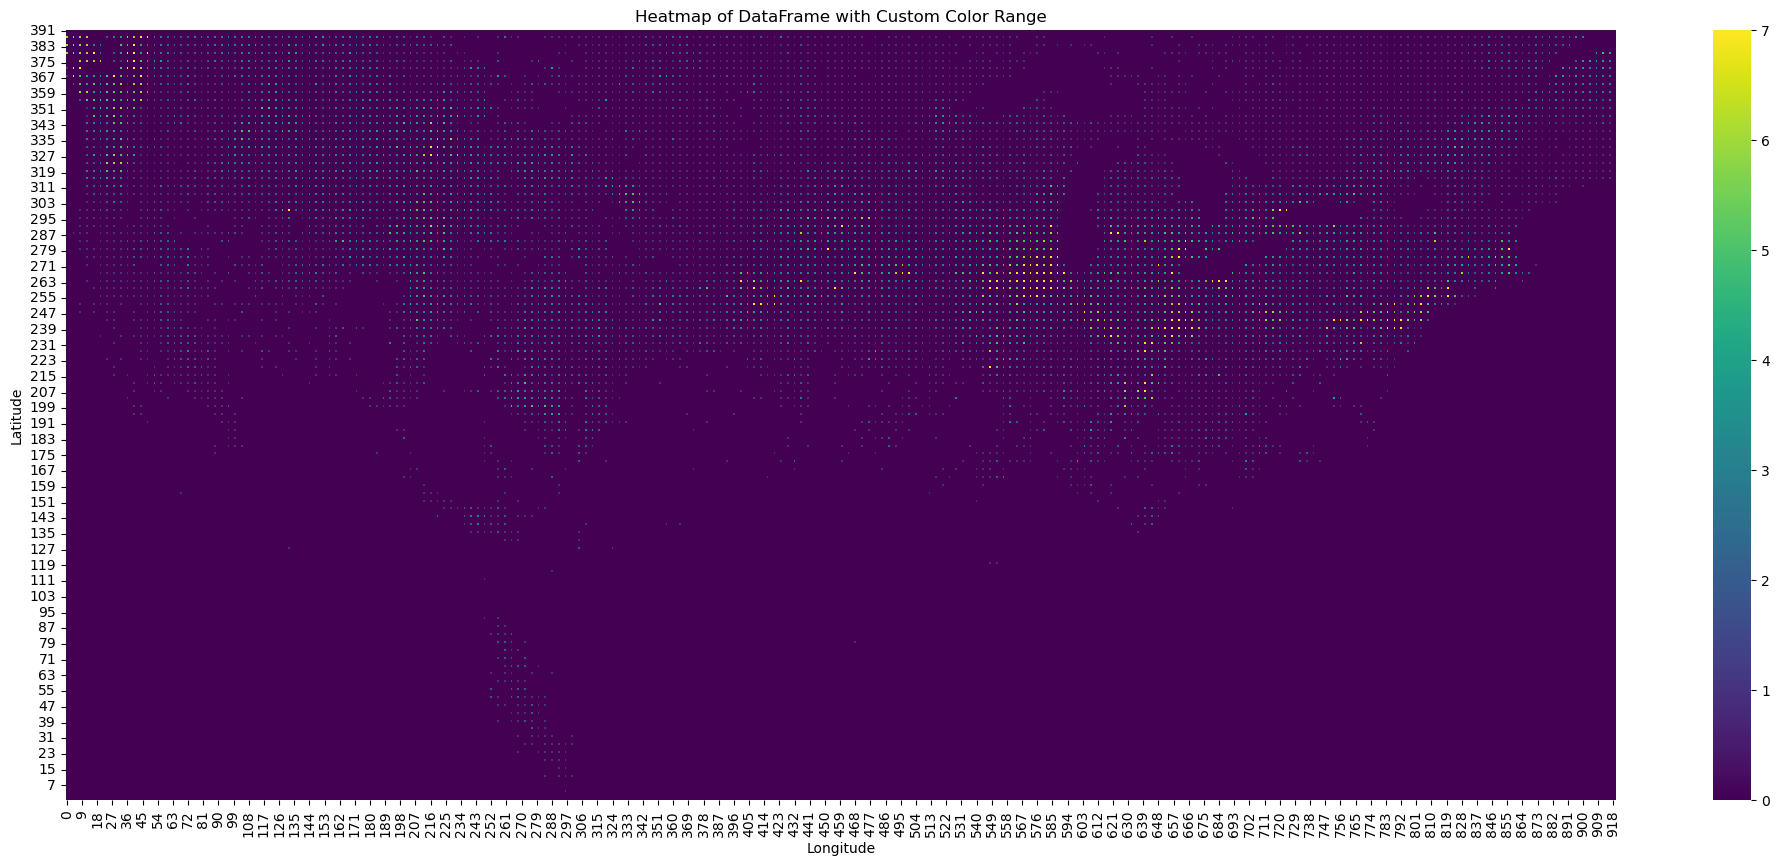

The largest number in the data is: 7


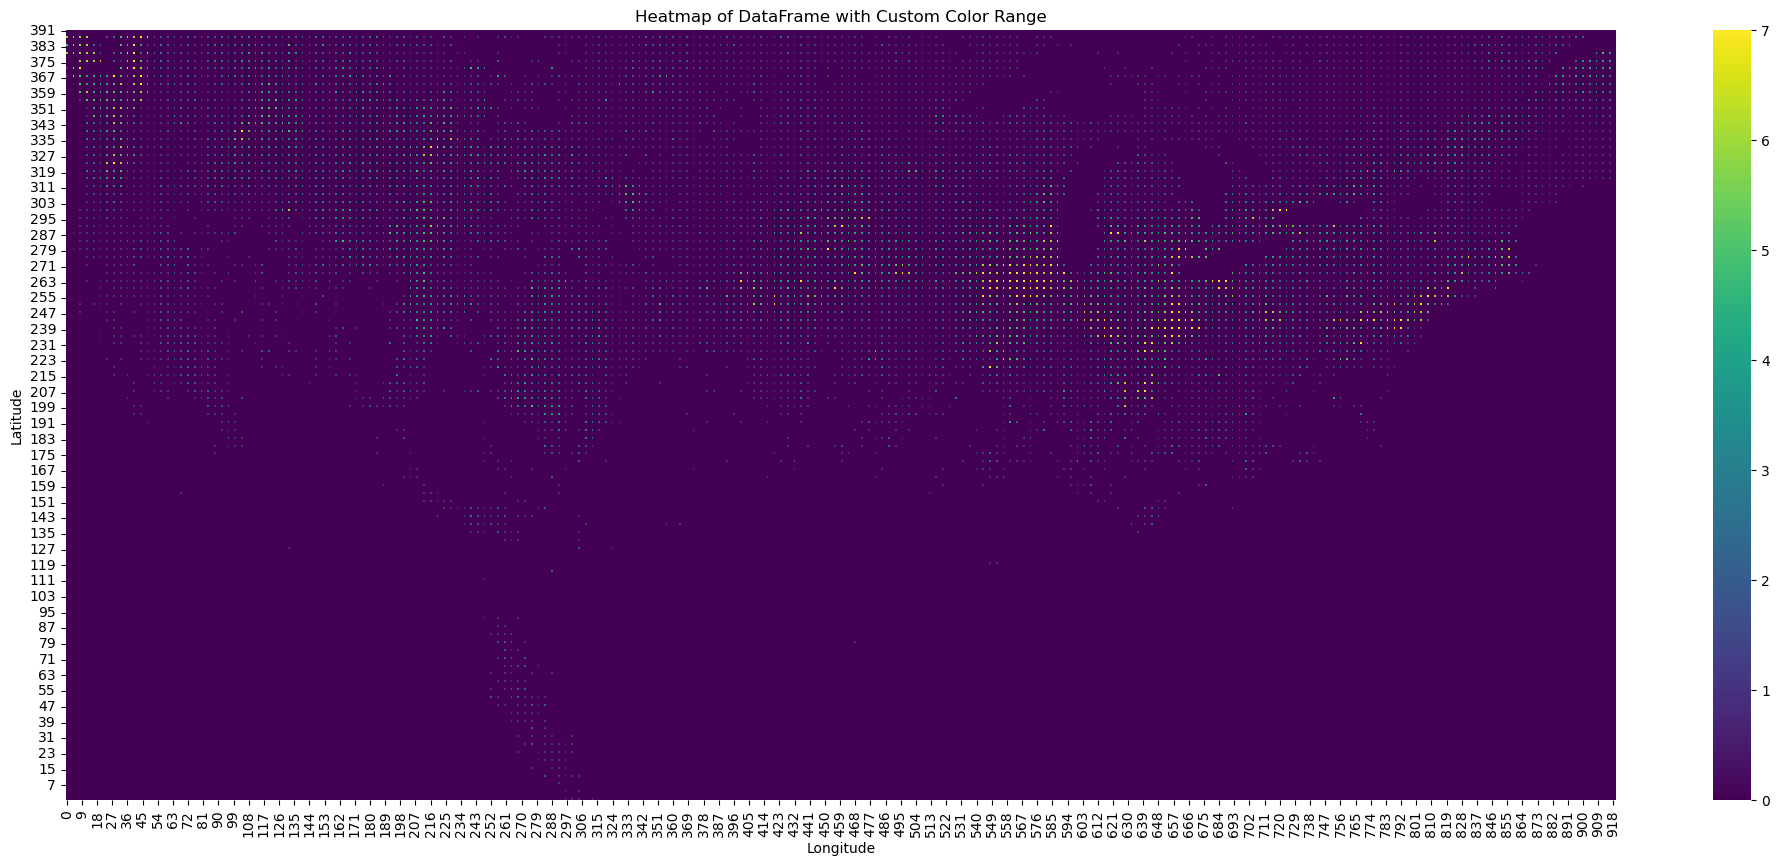

The largest number in the data is: 7


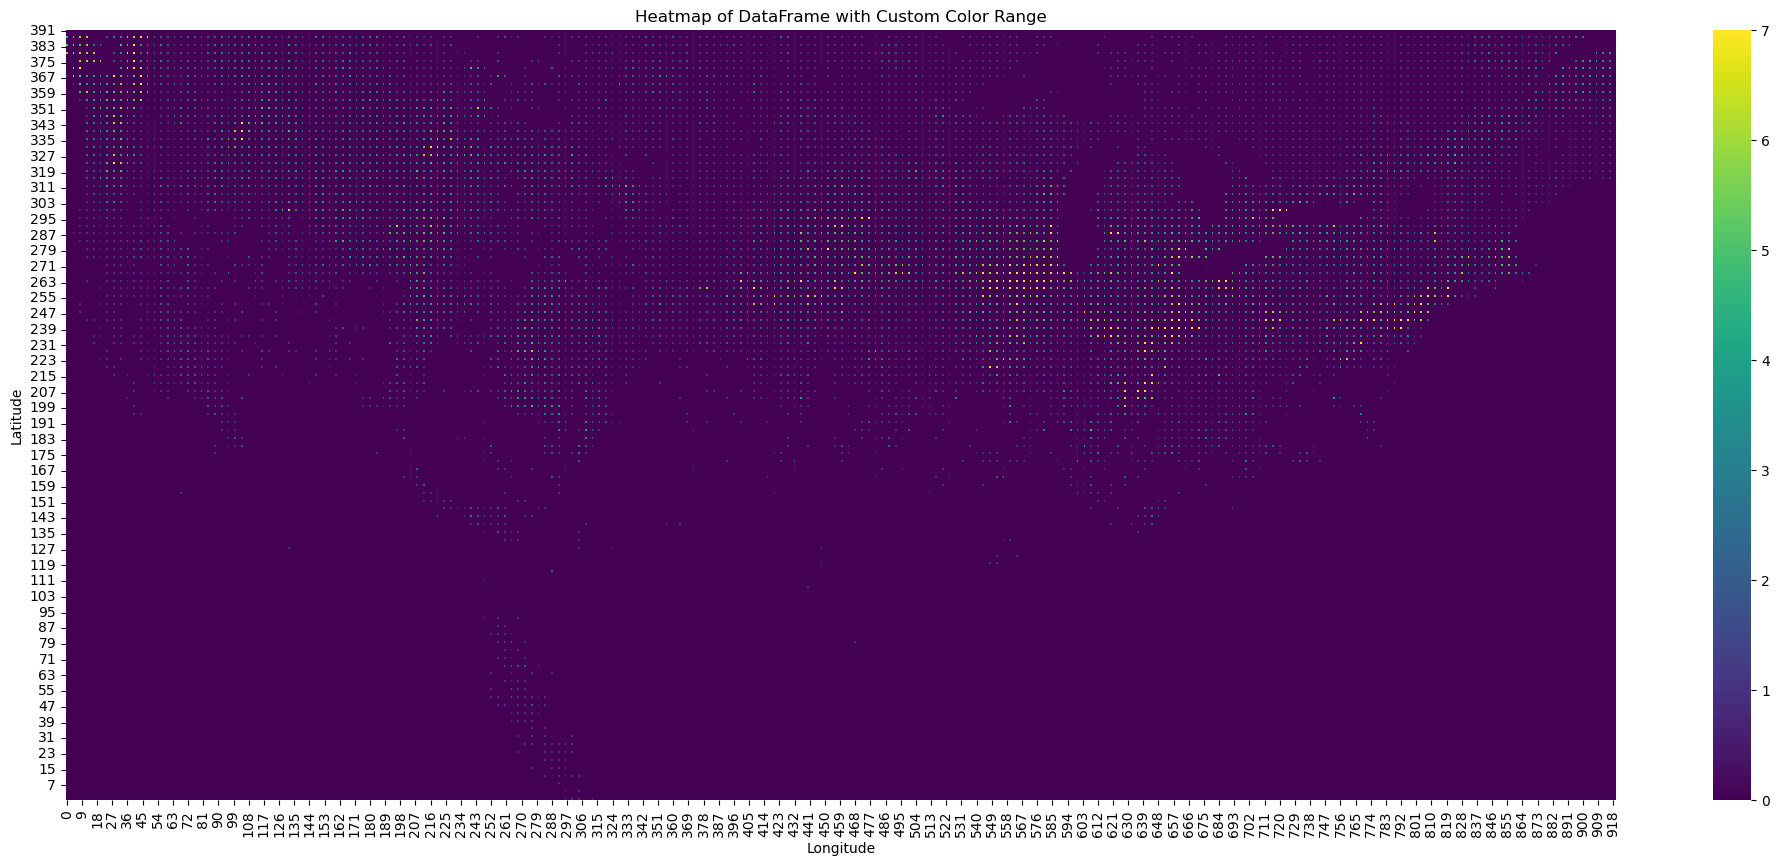

The largest number in the data is: 7


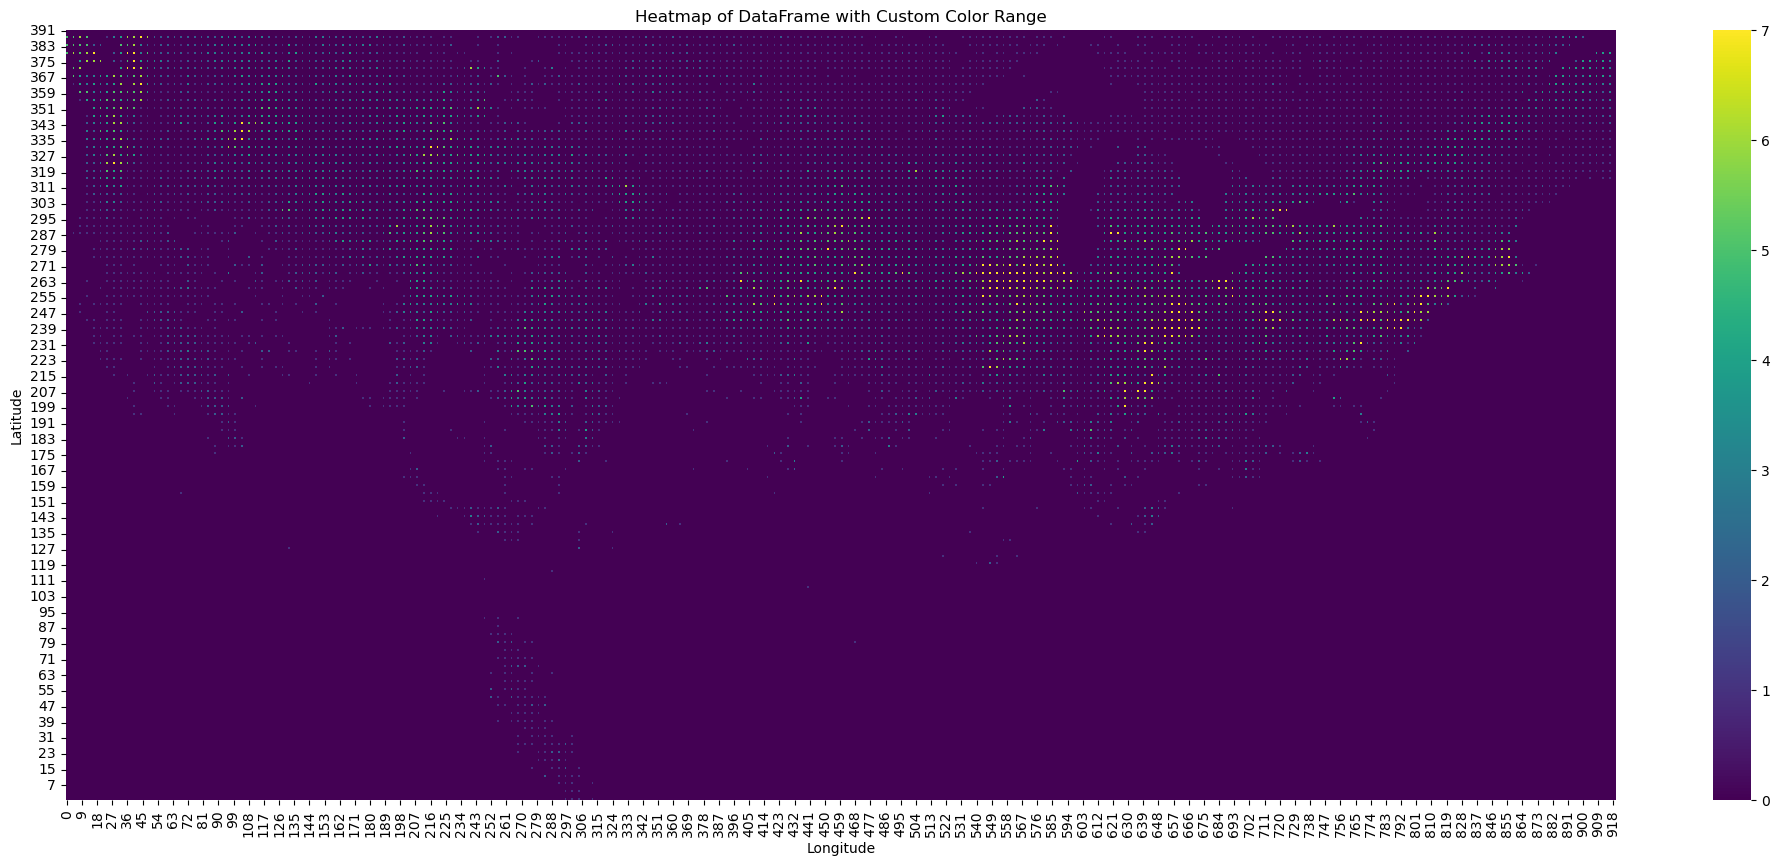

The largest number in the data is: 7


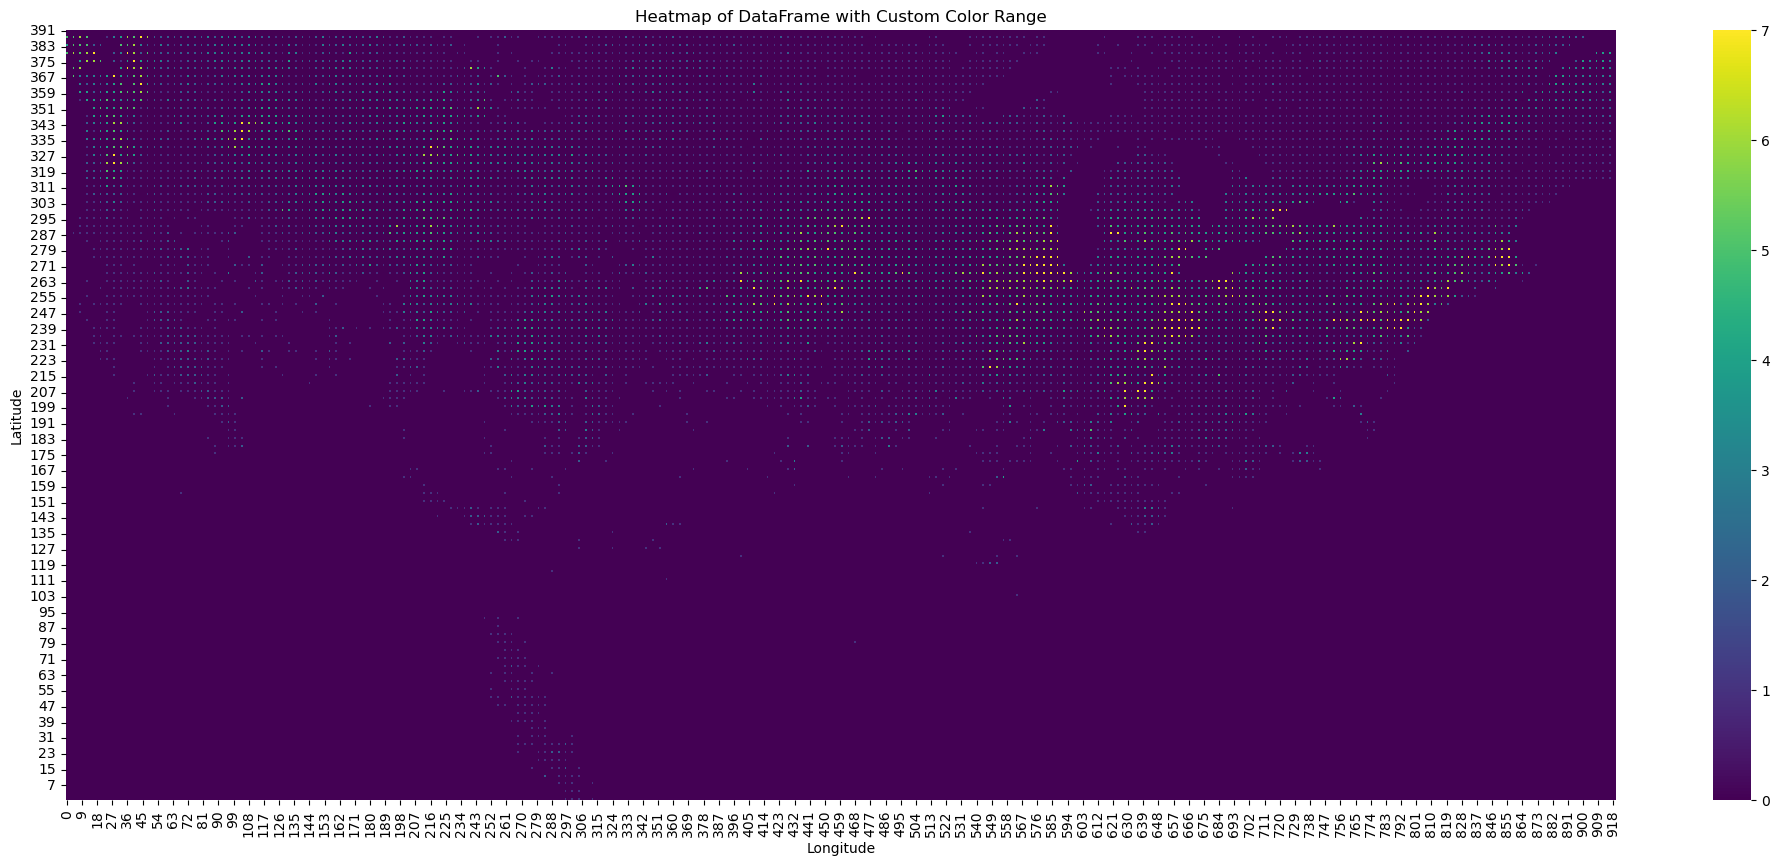

The largest number in the data is: 7


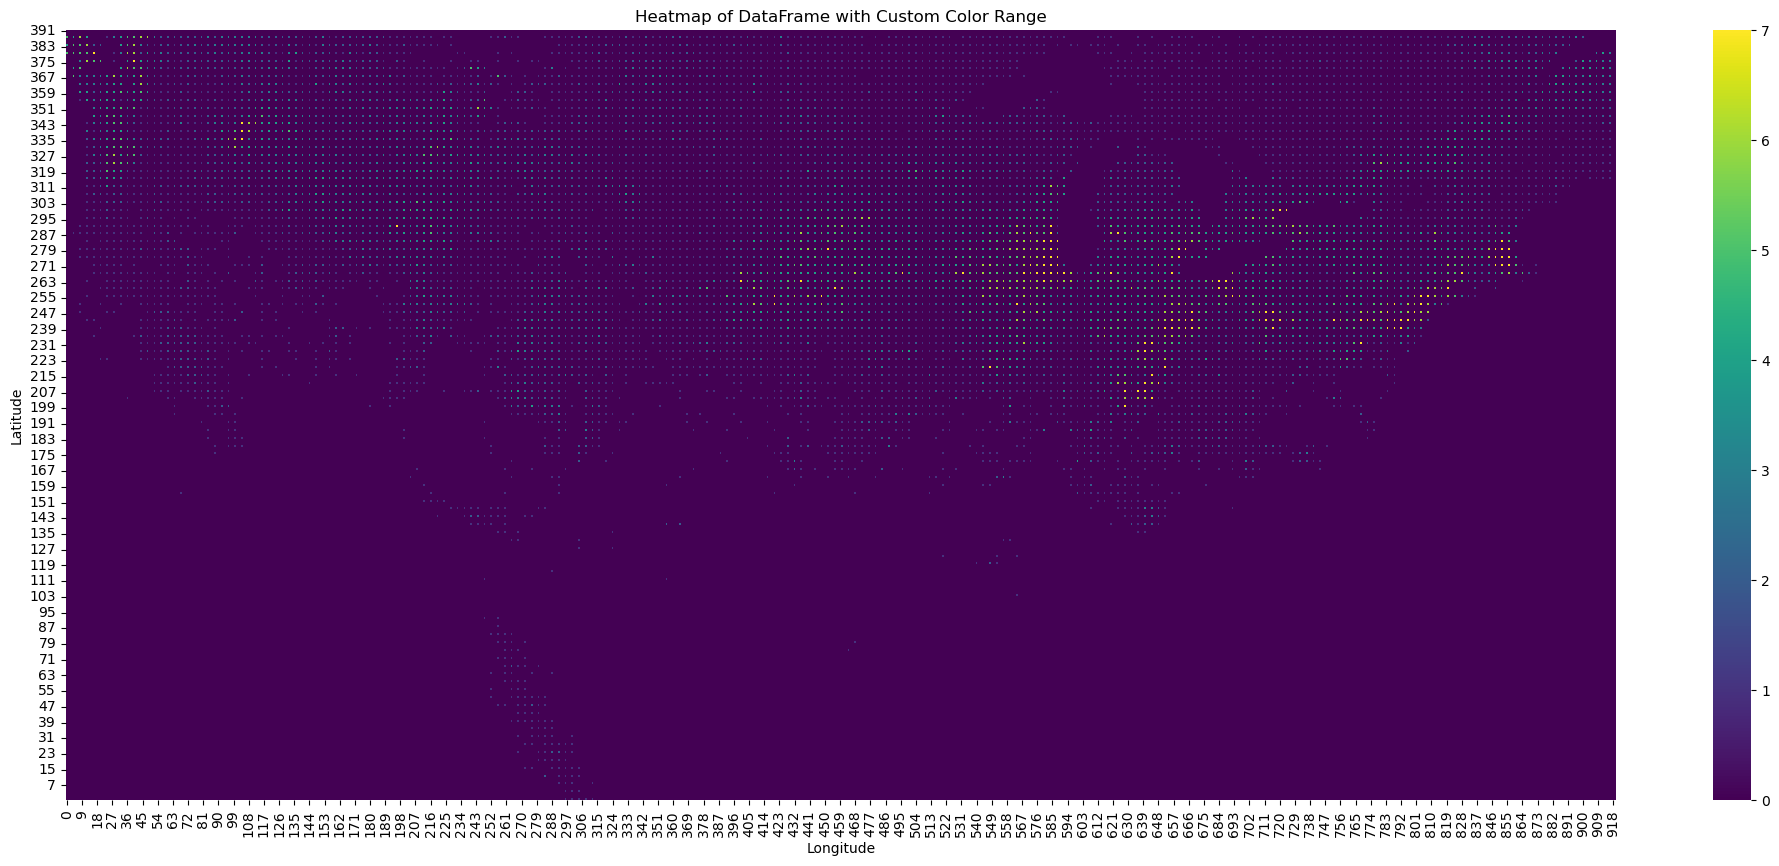

The largest number in the data is: 7


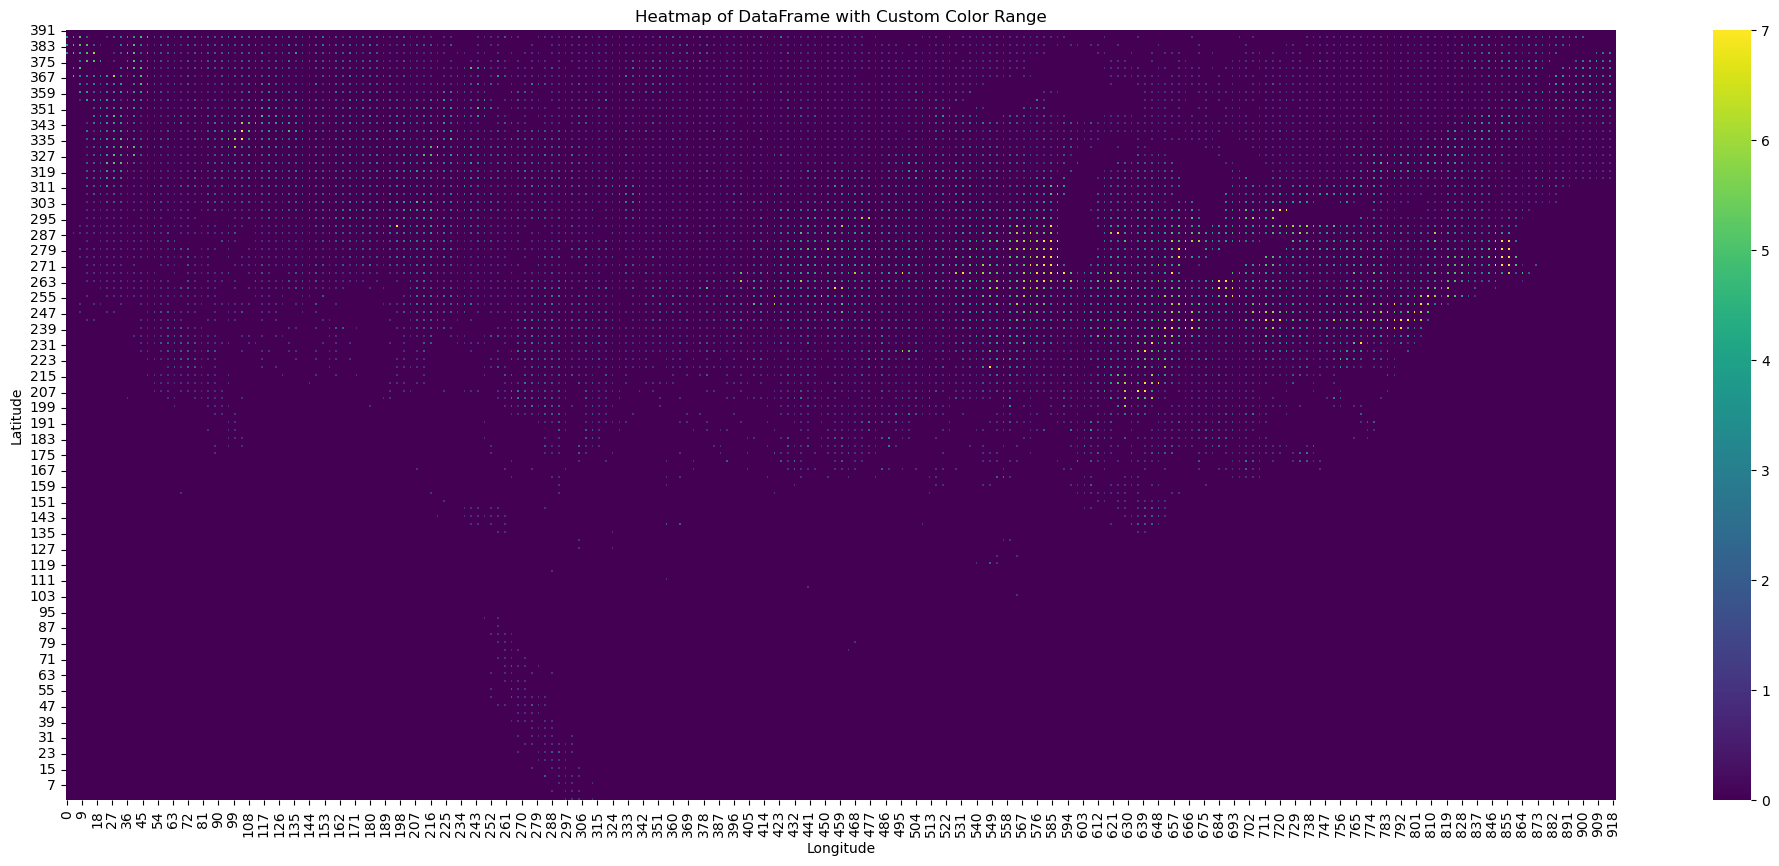

The largest number in the data is: 7


KeyboardInterrupt: 

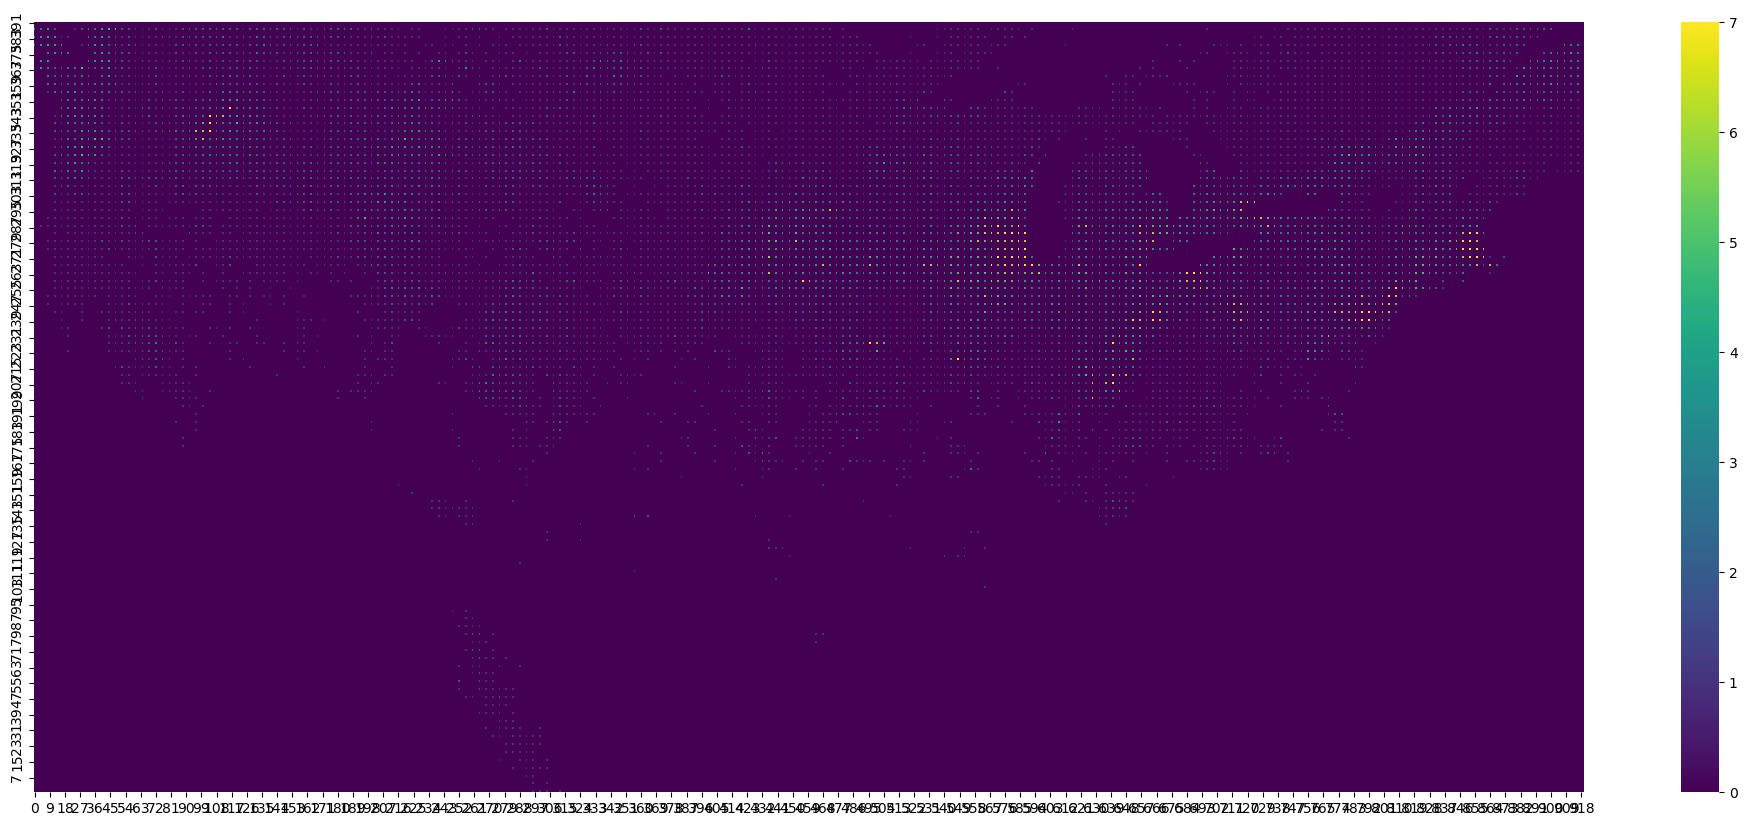

In [24]:
amerob_population = []
for i in range(1,53):
    read = pd.read_parquet(f'eBirdData/processed_amerob/{i}_amerob_2022.parquet')
    amerob_population.append(read.sum().sum())

    data = read.values
    max_value = data.max().max()
    print(f"The largest number in the data is: {max_value}")

    # Reverse the order of the latitude index
    data_reversed = read.iloc[::-1]

    # Set the color range with the maximum value
    plt.figure(figsize=(25, 10))
    sns.heatmap(data_reversed, cmap="viridis", cbar=True, vmin=0, vmax=max_value)

    plt.title("Heatmap of DataFrame with Custom Color Range")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

plt.plot(amerob_population)
plt.title('amerob')
plt.show()    

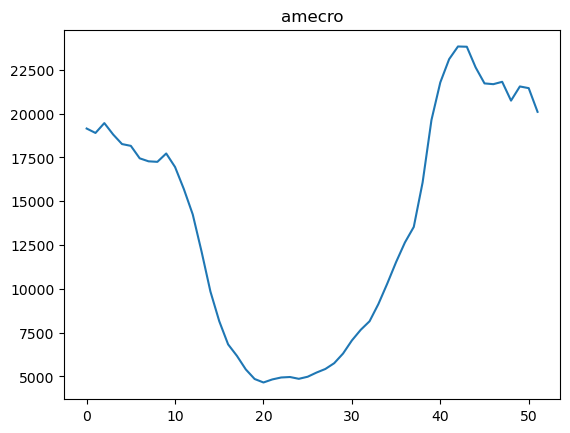

In [22]:
amecro_population = []
for i in range(1,53):
    read = pd.read_parquet(f'eBirdData/processed_amecro/{i}_amecro_2022.parquet')
    amecro_population.append(read.sum().sum())
plt.plot(amecro_population)
plt.title('amecro')
plt.show()    